In [1]:
import os
import re
import glob
import openai
import requests
import numpy as np
import pandas as pd

In [2]:
# Reading Whisper generated transcripts
original_transcripts_path = '../data/transcripts_from_whisper/' 

org_transcripts_df = pd.DataFrame(columns=["id", "text"])
# Extract IDs from filenames and text from files
for filename in os.listdir(original_transcripts_path):
    if filename.endswith(".txt"):
        file_id = filename[:3]
        with open(os.path.join(original_transcripts_path, filename), "r") as file:
            file_contents = file.read()
        org_transcripts_df = org_transcripts_df._append({"id": file_id, "text": file_contents}, ignore_index=True)

org_transcripts_df["id"] = org_transcripts_df["id"].astype("int64")

# Reading Whisper generated transcripts revised by GPT (gpt-3.5-turbo-0125) by asking the following prompt:
# "This interview involves a conversation with someone. Could you modify it by removing questions that don’t have an answer? Keep in mind that responses such as 'yes' and 'no' are also acceptable."   
revised_gpt_transcripts_path = '../data/gpt_revised_transcripts_Q_no_A/' 

df_train_revised = pd.read_csv(os.path.join(revised_gpt_transcripts_path, 'df_train.csv'))
df_dev_revised = pd.read_csv(os.path.join(revised_gpt_transcripts_path, 'df_dev.csv'))
df_test_revised = pd.read_csv(os.path.join(revised_gpt_transcripts_path, 'df_test.csv'))


In [3]:
# Reading label files
labels_dev_df = pd.read_csv('../data/labels/dev_split.csv')
labels_dev_df.columns = ['id', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']

labels_train_df = pd.read_csv('../data/labels/train_split.csv')
labels_train_df.columns = ['id', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']

labels_test_df = pd.read_csv('../data/labels/test_split.csv')
labels_test_df.columns = ['id', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']

In [4]:
# Merge dataframes on ID

df_train = pd.merge(labels_train_df, org_transcripts_df, on='id')
df_dev = pd.merge(labels_dev_df, org_transcripts_df, on='id')
df_test = pd.merge(labels_test_df, org_transcripts_df, on='id')

df_dev = df_dev.sort_values(by="id")
df_train = df_train.sort_values(by="id")
df_test = df_test.sort_values(by="id")

print('def_dev: ', df_dev.head())
print('max PHQ score in df_train: ', max(df_train['PHQ_Score']))

def_dev:      id  Gender  PHQ_Binary  PHQ_Score  PCL-C (PTSD)  PTSD Severity  \
0  300    male           0          2             0             25   
1  301    male           0          3             0             17   
2  306  female           0          0             0             21   
3  317    male           0          8             1             51   
4  320  female           0         11             1             64   

                                                text  
0   which will record your body. So I'll show you...  
1   Yeah, there's all sorts of different studies ...  
2   Okay, looks like we're good. But let's move a...  
3   Okay. How long is this? This is probably goin...  
4   Okay, everything looks good. Okay. Perfect. O...  
max PHQ score in df_train:  23


In [58]:
# # run for using the revised transcripts
# df_train = df_train_revised 
# df_dev = df_dev_revised
# df_test = df_test_revised

In [5]:
max(df_train['PHQ_Score'])

23

In [6]:
prompt1 = "Your task is to read the following text which is an interview with a person and to summarize the key points that might be related to the depression of the person."
prompt2 = "Your task is to read the following text which is an interview with a person and to summarize the key points that might be related to the depression of the person. Please be concise and write your response from the first-person perspective, as if you are the interviewee narrating about your own experiences."
prompt3 = "Could you provide a summary of the main points concerning the mental health of the interviewee from the interview?"
prompt4 = "Can you answer these questions from this text which is an interview with a person only with ‘YES’ or ‘NO’ or ‘To Some Extent’? If the question or corresponding answer is not found, answer 'Not Mentioned'. \
        These are the questions: \
        1. Have you felt emotionally and physically well lately? \
        2. Have you noticed significant changes in your mood, such as feeling persistently sad, empty, or hopeless? \
        3. Have you experienced difficulties with your sleep, such as trouble falling asleep, staying asleep, or waking up too early? \
        4. Are you finding it challenging to concentrate on tasks or make decisions? \
        5. Have you lost interest or pleasure in activities you used to enjoy? \
        6. Have you ever been diagnosed with depression or experienced prolonged periods of feeling down or hopeless in the past? \
        7. Have you ever been diagnosed with PTSD (Post-Traumatic Stress Disorder)? \
        8. Have you been experiencing any financial problems recently? \
        9. Do you find it challenging to socialize and prefer solitary activities, indicating introverted tendencies? \
        10. Have you had thoughts of death or suicide, or have you made any suicide attempts? \
        11. Have you ever served in the military?"

In [7]:
# prompt4 = "Can you answer these questions from this text which is an interview with a person only with ‘YES’ or ‘NO’ or ‘To Some Extent’? If the question or corresponding answer is not found, answer 'Not Mentioned'. \
#         These are the questions: \
#         1.	Have you been feeling more anxious or stressed than usual lately? \
#         2.	Do you find that certain activities or hobbies help you relax and unwind? \
#         3.	Do you have a support system of friends or family members you can rely on during difficult times? \
#         4.	Have you experienced any major life changes or transitions in the past year? \
#         5.	Do you feel that you have effective coping strategies for managing stress and difficult emotions? \
#         6.	Have you ever sought professional help or therapy for mental health concerns? \
#         7.	Do you feel that your current job or occupation contributes to feelings of stress or anxiety? \
#         8.	Have you felt emotionally and physically well lately? \
#         9.	Have you noticed significant changes in your mood, such as feeling persistently sad, empty, or hopeless? \
#         10.	Have you experienced difficulties with your sleep, such as trouble falling asleep, staying asleep, or waking up too early? \
#         11.	Are you finding it challenging to concentrate on tasks or make decisions? \
#         12.	Have you lost interest or pleasure in activities you used to enjoy? \
#         13.	Have you been experiencing any financial problems recently? \
#         14.	Do you find it challenging to socialize and prefer solitary activities, indicating introverted tendencies? \
#         15.	Have you ever been diagnosed with depression? \
#         16.	Have you ever been diagnosed with PTSD (Post-Traumatic Stress Disorder)? \
#         17.	Have you had thoughts of death or suicide, or have you made any suicide attempts? \
#         18.	Have you ever served in the military?"

In [8]:
prompt4

"Can you answer these questions from this text which is an interview with a person only with ‘YES’ or ‘NO’ or ‘To Some Extent’? If the question or corresponding answer is not found, answer 'Not Mentioned'.         These are the questions:         1. Have you felt emotionally and physically well lately?         2. Have you noticed significant changes in your mood, such as feeling persistently sad, empty, or hopeless?         3. Have you experienced difficulties with your sleep, such as trouble falling asleep, staying asleep, or waking up too early?         4. Are you finding it challenging to concentrate on tasks or make decisions?         5. Have you lost interest or pleasure in activities you used to enjoy?         6. Have you ever been diagnosed with depression or experienced prolonged periods of feeling down or hopeless in the past?         7. Have you ever been diagnosed with PTSD (Post-Traumatic Stress Disorder)?         8. Have you been experiencing any financial problems recentl

In [12]:
# GPT-3 cost estimator for all completions
from transformers import GPT2TokenizerFast

prompt = prompt4

# tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

token_counts = []
# for all tokens in all transcripts in dev, train, and test sets
for text in df_dev['text'].tolist() + df_train['text'].tolist() + df_test['text'].tolist():
    # tokenize text
    tokens = tokenizer.encode(text)
    # tokenize prompt
    prompt_tokens = tokenizer.encode(prompt)

    # append token count to list
    token_counts.append(len(tokens) + len(prompt_tokens) + 512)

# Final cost estimataion
print(f'Estimated cost: ${(sum(token_counts) / 1000 * 0.002)}')

Token indices sequence length is longer than the specified maximum sequence length for this model (1142 > 1024). Running this sequence through the model will result in indexing errors


Estimated cost: $1.513656


In [13]:
def make_prompt(prompt, text):
    return """{}\nHere is the interview between triple backticks:\n```{}```""".format(prompt, text)

# extract GPT completions for each transcript
def get_completions(prompt, text):
    prompt = make_prompt(prompt, text)
    # send request to API
    response = requests.post(
        "http://localhost:4100/parallel-requests",
        json={"prompts": prompt}
    )
    # get response
    response = response.json()
    return response["response"]

def get_completions_batch(prompt, texts):
    prompts = [make_prompt(prompt, text) for text in texts]
    prompts = "---".join(prompts)

    # send request to API
    response = requests.post(
        "http://localhost:4100/parallel-requests",
        json={"prompts": prompts}
    )

    # get response
    response = response.json()
    return response["response"]

In [14]:
prompt

"Can you answer these questions from this text which is an interview with a person only with ‘YES’ or ‘NO’ or ‘To Some Extent’? If the question or corresponding answer is not found, answer 'Not Mentioned'.         These are the questions:         1. Have you felt emotionally and physically well lately?         2. Have you noticed significant changes in your mood, such as feeling persistently sad, empty, or hopeless?         3. Have you experienced difficulties with your sleep, such as trouble falling asleep, staying asleep, or waking up too early?         4. Are you finding it challenging to concentrate on tasks or make decisions?         5. Have you lost interest or pleasure in activities you used to enjoy?         6. Have you ever been diagnosed with depression or experienced prolonged periods of feeling down or hopeless in the past?         7. Have you ever been diagnosed with PTSD (Post-Traumatic Stress Disorder)?         8. Have you been experiencing any financial problems recentl

In [254]:
# Explore the result
# get completion for the first transcript in the dev set
l = [300]
for id in l:
    print('id: ', id)
    # find dv_dev row with id
    row = df_dev[df_dev['id'] == id]
    # get the value of the text column
    text = row['text'].values[0]
    print('------------------------------------')
    print('This is the completion:')
    completions = get_completions(prompt, text)
    print(completions)

id:  300
------------------------------------
This is the completion:
['1. To Some Extent\n2. To Some Extent\n3. Yes\n4. To Some Extent\n5. To Some Extent\n6. Not Mentioned\n7. To Some Extent\n8. To Some Extent\n9. No\n10. To Some Extent\n11. To Some Extent\n12. To Some Extent\n13. To Some Extent\n14. No\n15. No\n16. No\n17. No\n18. No']


In [255]:
prompt

"Can you answer these questions from this text which is an interview with a person only with ‘YES’ or ‘NO’ or ‘To Some Extent’? If the question or corresponding answer is not found, answer 'Not Mentioned'.         These are the questions:         1.\tHave you been feeling more anxious or stressed than usual lately?         2.\tDo you find that certain activities or hobbies help you relax and unwind?         3.\tDo you have a support system of friends or family members you can rely on during difficult times?         4.\tHave you experienced any major life changes or transitions in the past year?         5.\tDo you feel that you have effective coping strategies for managing stress and difficult emotions?         6.\tHave you ever sought professional help or therapy for mental health concerns?         7.\tDo you feel that your current job or occupation contributes to feelings of stress or anxiety?         8.\tHave you felt emotionally and physically well lately?         9.\tHave you notic

In [12]:
# # Let's extract completions for all transcripts in the train, dev, and test sets
# # we will do this in batches of 10 to prevent API rate limits

# # get complettions in parallel in batches of 10
# df_dev['completions'] = ''
# for i in range(0, len(df_dev), 5):
#     print(f'Getting completions for dev transcripts {i} to {i+5}...')
#     # create a new column for completions
#     completions = get_completions_batch(prompt, df_dev['text'][i:i+5])
#     # convert list of completions to dataframe
#     df_completions = pd.DataFrame(completions, columns=['completions'])
#     # add completions to df_dev
#     df_dev['completions'][i:i+5] = df_completions['completions']

# df_dev.to_csv('df_dev_Q18.csv', index=False)

# df_train['completions'] = ''
# for i in range(0, len(df_train), 5):
#     print(f'Getting completions for train transcripts {i} to {i+5}...')
#     # create a new column for completions
#     completions = get_completions_batch(prompt, df_train['text'][i:i+5])
#     # convert list of completions to dataframe
#     df_completions = pd.DataFrame(completions, columns=['completions'])
#     # add completions to df_dev
#     df_train['completions'][i:i+5] = df_completions['completions']

# df_train.to_csv('df_train_Q18.csv', index=False)

# df_test['completions'] = ''
# for i in range(0, len(df_test), 5):
#     print(f'Getting completions for test transcripts {i} to {i+5}...')
#     # create a new column for completions
#     completions = get_completions_batch(prompt, df_test['text'][i:i+5])
#     # convert list of completions to dataframe
#     df_completions = pd.DataFrame(completions, columns=['completions'])
#     # add completions to df_dev
#     df_test['completions'][i:i+5] = df_completions['completions']
    
# df_test.to_csv('df_test_Q18.csv', index=False)

In [14]:
# # checking the ones that gpt API didn't send back a completion and get the comletions for them separately 
# import pandas as pd

# df = pd.read_csv('df_test_Q18.csv')

# # Check if completions column has NaN float items
# nan_values = df[pd.isna(df['completions'])]

# # Get the values of the id column for rows with NaN completions
# ids_with_nan_completions = nan_values['id'].tolist()

# print("Rows with NaN completions:")
# print(ids_with_nan_completions)

In [15]:
# import pandas as pd

# df = pd.read_csv('df_test_Q18.csv')

# # Check if completions column has ['']
# empty_list_values = df[df['completions'] == "['']"]

# # Get the values of the id column for rows with completions containing ['']
# ids_with_empty_list_completions = empty_list_values['id'].tolist()

# print("Rows with completions containing ['']:")
# print(ids_with_empty_list_completions)


In [16]:
# df.loc[df['id'] == 314, 'completions'] = """
# 1.To some extent
# 2.To some extent
# 3.Not mentioned
# 4.To some extent
# 5.To some extent
# 6.Yes
# 7.No
# 8.To some extent
# 9.To some extent
# 10.To some extent
# 11.No
# """

In [17]:
# df.loc[df['id'] == 314, 'completions'] 

In [18]:
# df.to_csv('df_train_Q10.csv', index=False)

In [19]:
# df = df_test
# l = [636]
# for id in l:
#     print('id: ', id)
#     row_index = df[df['id'] == id].index[0]
#     text = df.loc[row_index, 'text']
#     print('This is the completion:')
#     completions = get_completions(prompt, text)
#     print(completions)
#     print('------------------------------------')
#     df.loc[row_index, 'completions'] = completions

# df.to_csv('df_test_Q18.csv', index=False)

In [20]:
prompt

"Can you answer these questions from this text which is an interview with a person only with ‘YES’ or ‘NO’ or ‘To Some Extent’? If the question or corresponding answer is not found, answer 'Not Mentioned'.         These are the questions:         1. Have you felt emotionally and physically well lately?         2. Have you noticed significant changes in your mood, such as feeling persistently sad, empty, or hopeless?         3. Have you experienced difficulties with your sleep, such as trouble falling asleep, staying asleep, or waking up too early?         4. Are you finding it challenging to concentrate on tasks or make decisions?         5. Have you lost interest or pleasure in activities you used to enjoy?         6. Have you ever been diagnosed with depression or experienced prolonged periods of feeling down or hopeless in the past?         7. Have you ever been diagnosed with PTSD (Post-Traumatic Stress Disorder)?         8. Have you been experiencing any financial problems recentl

In [21]:
# # Extract answers for each question from prompt 4 completions
# import pandas as pd
# import re
# import os

# # Define the path
# # prompt_4_Q10_path = '../data/revised_transcripts_completions/prompt_4_Q10/'
# prompt_4_Q10_path = './'

# # Function to 
# #  answers from completions column
# def extract_answer(text):
#     # Regular expression to extract answers
#     pattern = r'(\b(?:Yes|No|To Some Extent|Not Mentioned)\b)'
#     matches = re.findall(pattern, text, flags=re.IGNORECASE)
#     if matches:
#         # print("extract_answer: ", matches[0].capitalize())
#         return matches[0].capitalize()  # Capitalize the answer
#     else:
#         return None

# # Process each CSV file in the directory
# for filename in os.listdir(prompt_4_Q10_path):
#     print(filename)
#     if filename.endswith('.csv'):
#         file_path = os.path.join(prompt_4_Q10_path, filename)
#         print("Processing:", filename)
        
#         # Read the CSV file
#         df = pd.read_csv(file_path)

#         # Extract answers for each row
#         for i in range(1, 12):
#             # print('i: ', i)
#             question_col_name = f'Q{i}'
#             df[question_col_name] = df['completions'].apply(lambda x: extract_answer(x.split(f'{i}. ')[1]) if f'{i}. ' in x else None)

#         # Drop the original completions column
#         # df.drop(columns=['completions'], inplace=True)

#         # Save the modified DataFrame to the same CSV file
#         df.to_csv(file_path, index=False)

#         print("Completed processing:", filename)



In [22]:
# import pandas as pd
# import re
# import os

# # Define the path
# csv_files_path = './'

# # Function to remove key points related to depression
# def remove_depression_key_points(text):
#     pattern = r'^\s*Key\s+points\s+related\s+to\s+the\s+depression\s+(?:of\s+the\s+person\s*)?(?:in\s+the\s+interview)?:\s*'
#     return re.sub(pattern, '', text, flags=re.IGNORECASE)

# # Process each CSV file in the directory
# for filename in os.listdir(csv_files_path):
#     print(filename)
#     if filename.endswith('.csv'):
#         file_path = os.path.join(csv_files_path, filename)
#         print("Processing:", filename)
        
#         # Read the CSV file
#         df = pd.read_csv(file_path)

#         # Remove key points related to depression from completions column
#         df['completions'] = df['completions'].apply(remove_depression_key_points)

#         # Save the modified DataFrame to the same CSV file
#         df.to_csv(file_path, index=False)

#         print("Completed processing:", filename)


In [9]:
import os
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Training and Evaluating and Testing

features_directory_org = './deproberta_features/original/'
features_directory_revised = './deproberta_features/revised/'

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep = ' ')

def ML_model_each_prompt(prompt, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)

    # Convert string representation of list to actual list using ast.literal_eval
    df_train['features_deproberta'] = df_train['features_deproberta'].apply(str_to_np_array)
    df_dev['features_deproberta'] = df_dev['features_deproberta'].apply(str_to_np_array)
    df_test['features_deproberta'] = df_test['features_deproberta'].apply(str_to_np_array)

    df_train['features_deproberta'] = df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    df_dev['features_deproberta'] = df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    df_test['features_deproberta'] = df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    # # Print the shape of each array in the 'features_deproberta' column
    # for i, array in enumerate(df_train['features_deproberta']):
    #     shape = array.shape
    #     # print(f"Shape of row {i} in 'features_deproberta' column: {shape}")

    # X_train = np.array(df_train['features_deproberta'])
    # X_dev = np.array(df_dev['features_deproberta'])
    # X_test = np.array(df_test['features_deproberta'])

    X_train = np.array([x.reshape(3) for x in df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in df_test['features_deproberta']])

    # print('X_train shape: ', X_train.shape)
    # print('X_dev shape: ', X_dev.shape)
    # print('X_test shape: ', X_test.shape)

    y_train = np.array(df_train['PHQ_Score'])
    y_dev = np.array(df_dev['PHQ_Score'])
    y_test = np.array(df_test['PHQ_Score'])

    # print('y_train shape: ', y_train.shape)
    # print('y_dev shape: ', y_dev.shape)
    # print('y_test shape: ', y_test.shape)

    # print(X_train)
    # print(y_train)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.01, 0.1, 10],
        'gamma': ['scale', 'auto'],
        'coef0': [0.0, 1.0, 2.0],
        'degree': [2, 3]
    }

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(SVR(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best SVR model from the grid search
    svr = grid_search.best_estimator_

    # Get the best parameters found by grid search
    best_params = grid_search.best_params_
    print("Best parameters found by grid search:")
    print(best_params)

    # Train the SVR model on X_train and y_train
    # svr.fit(X_train, y_train)

    # Predict on X_train and calculate the mean squared error and mean absolute error
    y_pred_train = svr.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print('RMSE for train: ', np.sqrt(mse_train))
    print('MAE for train: ', mae_train)

    print('SRV results based on fine-tuned DepRoberta model: ')

    # # Print predicted and true values for train set
    # print("Train set:")
    # for true, pred in zip(y_train, y_pred_train):
    #     print("True:", true, "\tPredicted:", pred)

    # Predict on X_dev and calculate the mean squared error and mean absolute error
    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev: ', np.sqrt(mse_dev))
    print('MAE for dev: ', mae_dev)

    # Print predicted and true values for dev set
    print("Dev set:")
    for true, pred in zip(y_dev, y_pred_dev):
        print("True:", true, "\tPredicted:", pred)

    # Predict on X_test and calculate the mean squared error and mean absolute error
    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test: ', np.sqrt(mse_test))
    print('MAE for test: ', mae_test)

    # Print predicted and true values for test set
    print("Test set:")
    for true, pred in zip(y_test, y_pred_test):
        print("True:", true, "\tPredicted:", pred)

ML_model_each_prompt('prompt1', features_directory_org)
ML_model_each_prompt('prompt2', features_directory_org)
ML_model_each_prompt('prompt3', features_directory_org)

ML_model_each_prompt('prompt1', features_directory_revised)
ML_model_each_prompt('prompt2', features_directory_revised)
ML_model_each_prompt('prompt3', features_directory_revised)
    

prompt:  prompt1
org_or_revised_dir:  ./deproberta_features/original/
Best parameters found by grid search:
{'C': 0.1, 'coef0': 1.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
RMSE for train:  5.525990729746132
MAE for train:  4.040287139309873
SRV results based on fine-tuned DepRoberta model: 
RMSE for dev:  4.639449803134079
MAE for dev:  3.441109984428553
Dev set:
True: 2 	Predicted: 2.360095186757261
True: 3 	Predicted: 1.0042347017796573
True: 0 	Predicted: 5.399030651954333
True: 8 	Predicted: 8.138318151640338
True: 11 	Predicted: 8.671414841668081
True: 20 	Predicted: 10.316668347447038
True: 8 	Predicted: 9.614305946689873
True: 5 	Predicted: 2.0359494783461454
True: 7 	Predicted: 4.847473562558012
True: 9 	Predicted: 9.315147927994143
True: 11 	Predicted: 4.151876131567001
True: 11 	Predicted: 9.78708762158551
True: 12 	Predicted: 2.6578822799594573
True: 9 	Predicted: 4.308787666320432
True: 9 	Predicted: 10.050649919628281
True: 2 	Predicted: 9.767454608985014
True: 1

In [10]:
import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Training and Evaluating and Testing

features_directory_org = './deproberta_features/original/'
features_directory_revised = './deproberta_features/revised/'

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_each_prompt(prompt, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)

    # Convert string representation of list to actual list using ast.literal_eval
    df_train['features_deproberta'] = df_train['features_deproberta'].apply(str_to_np_array)
    df_dev['features_deproberta'] = df_dev['features_deproberta'].apply(str_to_np_array)
    df_test['features_deproberta'] = df_test['features_deproberta'].apply(str_to_np_array)

    df_train['features_deproberta'] = df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    df_dev['features_deproberta'] = df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    df_test['features_deproberta'] = df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    X_train = np.array([x.reshape(3) for x in df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in df_test['features_deproberta']])

    y_train = np.array(df_train['PHQ_Score'])
    y_dev = np.array(df_dev['PHQ_Score'])
    y_test = np.array(df_test['PHQ_Score'])

    # Define the SVR model with desired parameters
    # svr = SVR(kernel='rbf', C=1.0, gamma='scale')

    # Decrease regularization (increase C)
    # svr = SVR(kernel='rbf', C=10, gamma='scale')


    # Experiment with different gamma values
    # svr = SVR(kernel='rbf', C=1.0, gamma=0.1)

    # Use polynomial kernel with higher degree
    svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')

    # svr = SVR(kernel='linear', C=1.0)
    # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')
    # svr = SVR(kernel='sigmoid', C=1.0, gamma='scale')

    # Train the SVR model on X_train and y_train
    svr.fit(X_train, y_train)

    # Predict on X_train and calculate the mean squared error and mean absolute error
    y_pred_train = svr.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print('RMSE for train: ', np.sqrt(mse_train))
    print('MAE for train: ', mae_train)

    print('SRV results based on fine-tuned DepRoberta model: ')

    # Predict on X_dev and calculate the mean squared error and mean absolute error
    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev: ', np.sqrt(mse_dev))
    print('MAE for dev: ', mae_dev)

    # Find indices where the predicted label differs by 10 from the true label in the dev set
    indices_dev = np.where(np.abs(y_dev - y_pred_dev) >= 10)[0]
    print("Indices in dev set where the predicted label differs by 10 or more from the true label:")
    print(indices_dev)
    for index in indices_dev:
        print("Index:", index, "\tTrue:", y_dev[index], "\tPredicted:", y_pred_dev[index])


    # Predict on X_test and calculate the mean squared error and mean absolute error
    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test: ', np.sqrt(mse_test))
    print('MAE for test: ', mae_test)

    # Find indices where the predicted label differs by 10 from the true label in the test set
    indices_test = np.where(np.abs(y_test - y_pred_test) >= 10)[0]
    print("Indices in test set where the predicted label differs by 10 or more from the true label:")
    print(indices_test)
    for index in indices_test:
        print("Index:", index, "\tTrue:", y_test[index], "\tPredicted:", y_pred_test[index])

    print("Test set:")
    for true, pred in zip(y_test, y_pred_test):
        print("True:", true, "\tPredicted:", pred)

ML_model_each_prompt('prompt1', features_directory_org)
ML_model_each_prompt('prompt2', features_directory_org)
ML_model_each_prompt('prompt3', features_directory_org)

ML_model_each_prompt('prompt1', features_directory_revised)
ML_model_each_prompt('prompt2', features_directory_revised)
ML_model_each_prompt('prompt3', features_directory_revised)


prompt:  prompt1
org_or_revised_dir:  ./deproberta_features/original/
RMSE for train:  5.50133584315232
MAE for train:  3.9763623154398977
SRV results based on fine-tuned DepRoberta model: 
RMSE for dev:  4.698108023172314
MAE for dev:  3.569728815995932
Indices in dev set where the predicted label differs by 10 or more from the true label:
[18 53]
Index: 18 	True: 17 	Predicted: 6.765236546402349
Index: 53 	True: 19 	Predicted: 8.255527086772037
RMSE for test:  5.988891494750371
MAE for test:  4.772404768937503
Indices in test set where the predicted label differs by 10 or more from the true label:
[13 22 23 31 32]
Index: 13 	True: 22 	Predicted: 10.111517234792545
Index: 22 	True: 19 	Predicted: 3.560910524137588
Index: 23 	True: 17 	Predicted: 4.137346915342112
Index: 31 	True: 16 	Predicted: 3.040716802000041
Index: 32 	True: 19 	Predicted: 4.846205055985582
Test set:
True: 5 	Predicted: 8.054070665725467
True: 13 	Predicted: 3.2982000200175343
True: 12 	Predicted: 7.42945337494975

In [11]:
# import re

# # Answers extraction for the new 18 questions 

# # Function to extract answers from completions column
# def extract_answers(text):
#     # Regular expression pattern to capture answers
#     pattern = r'\b(?:Yes|No|To Some Extent|Not Mentioned)\b'
#     matches = re.findall(pattern, text, flags=re.IGNORECASE)
#     if matches:
#         return [match.capitalize() for match in matches]
#     else:
#         return []
 
# # text = """
# # 1.     Not Mentioned.
# # 2.     Yes.
# # 3.     To Some Extent.
# # 4.     Yes.
# # 5.     To Some Extent.
# # 6.     Not Mentioned.
# # 7.     To Some Extent.
# # 8.     To Some Extent.
# # 9.     To Some Extent.
# # 10.  To Some Extent.
# # 11.  To Some Extent.
# # 12.  To Some Extent.
# # 13.  To Some Extent.
# # 14.  To Some Extent.
# # 15.  Not Mentioned.
# # 16.  Not Mentioned.
# # 17.  To Some Extent.
# # 18.  No.
# # """
# # answers = extract_answers(text)
# # for i, answer in enumerate(answers, start=1):
# #     print(f"Question {i}: {answer}")

# # Process each CSV file in the directory
# for filename in os.listdir('./'):
#     if filename.endswith('.csv'):
#         file_path = os.path.join(prompt_4_Q10_path, filename)
#         print("Processing:", filename)
        
#         # Read the CSV file
#         df = pd.read_csv(file_path)

#         # Extract answers for each row
#         for i in range(1, 19):
#             question_col_name = f'Q{i}'
#             # df[question_col_name] = df['completions'].apply(lambda x: extract_answer(x.split(f'{i}. ')[1]) if f'{i}. ' in x else None)
#             df[question_col_name] = df['completions'].apply(lambda x: extract_answer(x.split(f'{i}.', 1)[-1].strip()) if f'{i}.' in x else None)

#         df.sort_values(by='id', inplace=True)
        
#         # Save the modified DataFrame to the same CSV file
#         df.to_csv(file_path, index=False)

#         print("Completed processing:", filename)


In [28]:

    # # Iterate over rows with missing values
    # for index, row in rows_with_missing_values_train.iterrows():
    #     missing_columns = row[row.isnull()].index.tolist()
    #     print("train ID:", row['id'])
    #     print("Columns with missing values:", missing_columns)

    #     answers = extract_answers(row['completions'])
    #     for i, answer in enumerate(answers, start=1):
    #         question_col_name = f'Q{i}'
    #         if question_col_name in missing_columns:
    #             print(f"Answer for {question_col_name}: {answer}")

    #     # # Extract answers for each row with missing values in specific columns
    #     # answers = extract_answer(row['completions'])
    #     # print('answers: ', answers)
    #     # for i, answer in enumerate(answers, start=1):
    #     #     question_col_name = f'Q{i}'
    #     #     if question_col_name in missing_columns:
    #     #         print(f"Answer for {question_col_name}: {answer}")

    # for index, row in rows_with_missing_values_dev.iterrows():
    #     missing_columns = row[row.isnull()].index.tolist()
    #     print("dev ID:", row['id'])
    #     print("Columns with missing values:", missing_columns)
        
    #     # Extract answers for each row with missing values in specific columns
    #     answers = extract_answer(row['completions'])
    #     for i, answer in enumerate(answers, start=1):
    #         question_col_name = f'Q{i}'
    #         if question_col_name in missing_columns:
    #             print(f"Answer for {question_col_name}: {answer}")

    #     # for i in range(1, 12):
    #     #     question_col_name = f'Q{i}'
    #     #     if question_col_name in missing_columns:
    #     #         # Extract answer only if the column is missing in this row
    #     #         answer = extract_answer(row['completions'].split(f'{i}. ')[1]) if f'{i}. ' in row['completions'] else None
    #     #         print(f"Answer for {question_col_name}: {answer}")

    # for index, row in rows_with_missing_values_test.iterrows():
    #     missing_columns = row[row.isnull()].index.tolist()
    #     print("test ID:", row['id'])
    #     print("Columns with missing values:", missing_columns)

    #     # Extract answers for each row with missing values in specific columns
    #     answers = extract_answer(row['completions'])
    #     for i, answer in enumerate(answers, start=1):
    #         question_col_name = f'Q{i}'
    #         if question_col_name in missing_columns:
    #             print(f"Answer for {question_col_name}: {answer}")

    #     # for i in range(1, 12):
    #     #     question_col_name = f'Q{i}'
    #     #     if question_col_name in missing_columns:
    #     #         # Extract answer only if the column is missing in this row
    #     #         answer = extract_answer(row['completions'].split(f'{i}. ')[1]) if f'{i}. ' in row['completions'] else None
    #     #         print(f"Answer for {question_col_name}: {answer}")


In [12]:
import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# preprocessing prompt4 results. (11 questions)
# features_directory_org = './deproberta_features/original/'
# features_directory_revised = './deproberta_features/revised/'
features_directory = './'

# Define a dictionary for mapping
# mapping_dict = {
#     'Yes': 1,
#     'No': 0,
#     'To some extent': 0.5,
#     'Not mentioned': np.nan
# }

# mapping_dict = {
#     'Yes'.strip(): 1,
#     'Yes ': 1,
#     'No'.strip(): 0,
#     'To some extent'.strip(): 0.5
# }

mapping_dict = {
    'Yes': 1,
    'Yes ': 1,
    ' Yes': 1,
    ' Yes ': 1,
    'No': 0,
    'No ': 0,
    ' No': 0,
    ' No ': 0,
    'To some extent': 0.5,
    'To some extent ': 0.5,
    ' To some extent': 0.5,
    'To Some Extent': 0.5,
    'To Some Extent ': 0.5,
    ' To Some Extent': 0.5,
    ' To Some Extent ': 0.5,
    'Not mentioned': np.nan,
    'Not mentioned ': np.nan,
    ' Not mentioned': np.nan,
    ' Not mentioned ': np.nan,
    'Not Mentioned': np.nan,
    'Not Mentioned ': np.nan,
    ' Not Mentioned': np.nan,
    ' Not Mentioned ': np.nan
}


def mapping_questions_promp4(prompt, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)

    # Find rows with missing values
    rows_with_missing_values_train = df_train[df_train.isnull().any(axis=1)]
    rows_with_missing_values_dev = df_dev[df_dev.isnull().any(axis=1)]
    rows_with_missing_values_test = df_test[df_test.isnull().any(axis=1)]

    for index, row in rows_with_missing_values_train.iterrows():
        missing_columns = row[row.isnull()].index.tolist()
        print("train ID:", row['id'])
        print("Columns with missing values:", missing_columns)

    for index, row in rows_with_missing_values_dev.iterrows():
        missing_columns = row[row.isnull()].index.tolist()
        print("dev ID:", row['id'])
        print("Columns with missing values:", missing_columns)

    for index, row in rows_with_missing_values_test.iterrows():
        missing_columns = row[row.isnull()].index.tolist()
        print("test ID:", row['id'])
        print("Columns with missing values:", missing_columns)


    # Filter columns to only include those starting with 'Q'
    q_columns = [col for col in df_train.columns if col.startswith('Q')]

    # Replace values using the mapping dictionary only for q_columns
    df_train[q_columns] = df_train[q_columns].replace(mapping_dict)
    df_dev[q_columns] = df_dev[q_columns].replace(mapping_dict)
    df_test[q_columns] = df_test[q_columns].replace(mapping_dict)

    # print(df_train.head())

    # for col in q_columns:
    #     most_frequent_value = df_train[col].mode()[0]  # Find the most frequent value in the column
    #     df_train[col].fillna(most_frequent_value, inplace=True)  # Fill NaN values with the most frequent value

    # for col in q_columns:
    #     most_frequent_value = df_dev[col].mode()[0]
    #     df_dev[col].fillna(most_frequent_value, inplace=True)

    # for col in q_columns:
    #     most_frequent_value = df_test[col].mode()[0]
    #     df_test[col].fillna(most_frequent_value, inplace=True)

    for col in q_columns:
        # print('df_train unique: ', df_train[col].unique())
        average_value = df_train[col].mean()  # Find the average value in the column
        df_train[col].fillna(average_value, inplace=True)  # Fill NaN values with the average value

    for col in q_columns:
        # print('df_dev unique: ', df_dev[col].unique())
        average_value = df_dev[col].mean()
        df_dev[col].fillna(average_value, inplace=True)

    for col in q_columns:
        # print('df_test unique: ', df_test[col].unique())
        average_value = df_test[col].mean()
        df_test[col].fillna(average_value, inplace=True)
    
    return (df_train, df_dev, df_test)


df_train_Q10_org, df_dev_Q10_org, df_test_Q10_org = mapping_questions_promp4('Q10', features_directory)
df_train_Q10_revised, df_dev_Q10_revised, df_test_Q10_revised = mapping_questions_promp4('Q10', features_directory)

# df_train_Q18, df_dev_Q18, df_test_Q18 = mapping_questions_promp4('Q18', features_directory)
# df_train_Q10, df_dev_Q10, df_test_Q10 = mapping_questions_promp4('Q10', features_directory)


# print('after: ', df_train_Q10_org.head())

def count_values(row):
    to_some_extent_count = row[row == 0.5].count()
    non_mentioned_count = row[(row != 0.0) & (row != 0.5) & (row != 1.0)].count()
    return pd.Series({'Non Mentioned count': non_mentioned_count, 'To Some Extent count': to_some_extent_count})

dfs_count = [df_train_Q10_org, df_dev_Q10_org, df_test_Q10_org]
for df in dfs_count:
    selected_columns = df[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']]
    result_df = selected_columns.apply(count_values, axis=1)
    result_df = pd.concat([df, result_df], axis=1)

    # Get the name of the DataFrame object itself
    df_name = [name for name, var in locals().items() if var is df][0]
    # Save the DataFrame to a CSV file with its name
    result_df.to_csv(f'{df_name}_count.csv', index=False)  # Change index to False if you don't want to save row indices




prompt:  Q10
org_or_revised_dir:  ./
test ID: 669
Columns with missing values: ['PTSD Severity']
test ID: 683
Columns with missing values: ['PTSD Severity']
prompt:  Q10
org_or_revised_dir:  ./
test ID: 669
Columns with missing values: ['PTSD Severity']
test ID: 683
Columns with missing values: ['PTSD Severity']


/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/918250209.py:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[q_columns] = df_test[q_columns].replace(mapping_dict)
/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/918250209.py:119: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the ori

In [13]:
# # Training for new 18 questions

# import os
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np
# import pandas as pd

# # Training and Evaluating and Testing

# features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
# features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# # Function to convert string representation to NumPy array
# def str_to_np_array(s):
#     s = s.strip('[]')  # Remove square brackets
#     return np.fromstring(s, sep=' ')

# def ML_model_prompt4_merged(prompt, org_revised, org_or_revised_dir):
#     print('prompt: ', prompt)
#     print('org_or_revised_dir: ', org_or_revised_dir)

#     df_dev = pd.DataFrame()
#     df_train = pd.DataFrame()
#     df_test = pd.DataFrame()
#     csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
#     for file in csv_files:
#         file_path = os.path.join(org_or_revised_dir, file)
#         if prompt in file:
#             if 'train' in file:
#                 df_train = pd.read_csv(file_path)
#             elif 'dev' in file:
#                 df_dev = pd.read_csv(file_path)
#                 df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
#             elif 'test' in file:
#                 df_test = pd.read_csv(file_path)

#     df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
#     df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
#     df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
#     if org_revised == 'org':
#         merged_df_train = pd.merge(df_train, df_train_Q18, on='id', how='inner')
#         merged_df_dev = pd.merge(df_dev, df_dev_Q18, on='id', how='inner')
#         merged_df_test = pd.merge(df_test, df_test_Q18, on='id', how='inner')
#     elif org_revised =='revised':
#         merged_df_train = pd.merge(df_train, df_train_Q18, on='id', how='inner')
#         merged_df_dev = pd.merge(df_dev, df_dev_Q18, on='id', how='inner')
#         merged_df_test = pd.merge(df_test, df_test_Q18, on='id', how='inner')

#     # print('merged_df_dev: ', merged_df_dev)

#     # Get deproberta featrures
#     # Convert string representation of list to actual list using ast.literal_eval
#     merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
#     merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
#     merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

#     merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
#     merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
#     merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

#     X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
#     X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
#     X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

#     # Extract additional features
#     additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18']].values
#     # Concatenate additional features with existing features_deproberta
#     X_train = np.concatenate((X_train, additional_features), axis=1)

#     # Similarly for dev and test sets
#     additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18']].values
#     X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

#     additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18']].values
#     X_test = np.concatenate((X_test, additional_features_test), axis=1)

#     print('X_train shape: ', X_train.shape)
#     print('X_dev shape: ', X_dev.shape)
#     print('X_test shape: ', X_test.shape)

#     y_train = np.array(merged_df_train['PHQ_Score'])
#     y_dev = np.array(merged_df_dev['PHQ_Score'])
#     y_test = np.array(merged_df_test['PHQ_Score'])

#     # Define the SVR model with desired parameters
#     # svr = SVR(kernel='rbf', C=1.0, gamma='scale')

#     # Decrease regularization (increase C)
#     # svr = SVR(kernel='rbf', C=10, gamma='scale')


#     # Experiment with different gamma values
#     # svr = SVR(kernel='rbf', C=1.0, gamma=0.1)

#     # Use polynomial kernel with higher degree
#     # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')

#     svr = SVR(kernel='linear', C=1.0)
#     # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')
#     # svr = SVR(kernel='sigmoid', C=1.0, gamma='scale')

#     # Train the SVR model on X_train and y_train
#     svr.fit(X_train, y_train)

#     # Predict on X_train and calculate the mean squared error and mean absolute error
#     y_pred_train = svr.predict(X_train)
#     mse_train = mean_squared_error(y_train, y_pred_train)
#     mae_train = mean_absolute_error(y_train, y_pred_train)
#     print('RMSE for train: ', np.sqrt(mse_train))
#     print('MAE for train: ', mae_train)

#     print('SRV results based on fine-tuned DepRoberta model: ')

#     # Predict on X_dev and calculate the mean squared error and mean absolute error
#     y_pred_dev = svr.predict(X_dev)
#     mse_dev = mean_squared_error(y_dev, y_pred_dev)
#     mae_dev = mean_absolute_error(y_dev, y_pred_dev)
#     print('RMSE for dev: ', np.sqrt(mse_dev))
#     print('MAE for dev: ', mae_dev)

#     # Find indices where the predicted label differs by 10 from the true label in the dev set
#     indices_dev = np.where(np.abs(y_dev - y_pred_dev) >= 10)[0]
#     print("Indices in dev set where the predicted label differs by 10 or more from the true label:")
#     print(indices_dev)
#     for index in indices_dev:
#         print("Index:", index, "\tTrue:", y_dev[index], "\tPredicted:", y_pred_dev[index])


#     # Predict on X_test and calculate the mean squared error and mean absolute error
#     y_pred_test = svr.predict(X_test)
#     mse_test = mean_squared_error(y_test, y_pred_test)
#     mae_test = mean_absolute_error(y_test, y_pred_test)
#     print('RMSE for test: ', np.sqrt(mse_test))
#     print('MAE for test: ', mae_test)

#     # Find indices where the predicted label differs by 10 from the true label in the test set
#     indices_test = np.where(np.abs(y_test - y_pred_test) >= 10)[0]
#     print("Indices in test set where the predicted label differs by 10 or more from the true label:")
#     print(indices_test)
#     for index in indices_test:
#         print("Index:", index, "\tTrue:", y_test[index], "\tPredicted:", y_pred_test[index])

#     print("Test set:")
#     for true, pred in zip(y_test, y_pred_test):
#         print("True:", true, "\tPredicted:", pred)

# ML_model_prompt4_merged('prompt1', 'org', features_directory_org)
# ML_model_prompt4_merged('prompt2', 'org', features_directory_org)
# ML_model_prompt4_merged('prompt3', 'org', features_directory_org)

# ML_model_prompt4_merged('prompt1', 'revised', features_directory_revised)
# ML_model_prompt4_merged('prompt2', 'revised', features_directory_revised)
# ML_model_prompt4_merged('prompt3', 'revised', features_directory_revised)




In [15]:
import matplotlib.font_manager
print([f.name for f in matplotlib.font_manager.fontManager.ttflist])


['STIXSizeTwoSym', 'cmb10', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans', 'cmss10', 'DejaVu Serif Display', 'cmr10', 'DejaVu Sans Mono', 'DejaVu Sans', 'STIXGeneral', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXGeneral', 'STIXSizeTwoSym', 'STIXNonUnicode', 'STIXSizeThreeSym', 'STIXGeneral', 'DejaVu Sans', 'STIXSizeOneSym', 'cmtt10', 'DejaVu Serif', 'cmsy10', 'STIXGeneral', 'STIXSizeThreeSym', 'cmex10', 'DejaVu Sans', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans Mono', 'cmmi10', 'STIXSizeFourSym', 'DejaVu Sans Display', 'STIXSizeFourSym', 'DejaVu Serif', 'STIXSizeFiveSym', 'STIXNonUnicode', 'STIXNonUnicode', 'Helvetica Neue', '2  Tehran', 'MRT_Nil 2', 'MRT_Afrigha', 'Herculanum', 'Skia', 'Apple Braille', '.SF Georgian Rounded', '2  Mashhad', 'MRT_Flow Bold', 'MRT_Typographer Bold', 'Helvetica', 'MRT_Pashtu Light', 'MRT_Modern_1', 'STIXNonUnicode', 'MRT_Poster_18', 'B Esfehan', 'MRT_Silicon', 'Tahoma', 'MRT_Farasha Bold', 'MRT_Damas', 'B Vahid', 'B Farnaz', 'STIXSizeThreeSym', 'B N

prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train shape:  (163, 14)
X_dev shape:  (56, 14)
X_test shape:  (56, 14)
RMSE for train:  4.237505739306279
MAE for train:  3.1683572265446003
SRV results based on fine-tuned DepRoberta model: 
RMSE for dev:  4.51556629375071
MAE for dev:  3.1674283345500123
Indices in dev set where the predicted label differs by 10 or more from the true label:
[ 2 11 19 26]
Index: 2 	True: 0 	Predicted: 10.4456870518048
Index: 11 	True: 16 	Predicted: 5.043789998776601
Index: 19 	True: 17 	Predicted: 5.7017652768535605
Index: 26 	True: 0 	Predicted: 10.106349664401137
RMSE for test:  5.0709971875435285
MAE for test:  4.220379518544199
Indices in test set where the predicted label differs by 10 or more from the true label:
[47]
Index: 47 	True: 20 	Predicted: 9.688028590265017
Test set:
True: 5 	Predicted: 12.404214926067425
True: 13 	Predicted: 9.036367470047978
True: 12 	Predicted: 4.574652638131002

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/3709590635.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/3709590635.py:58: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(


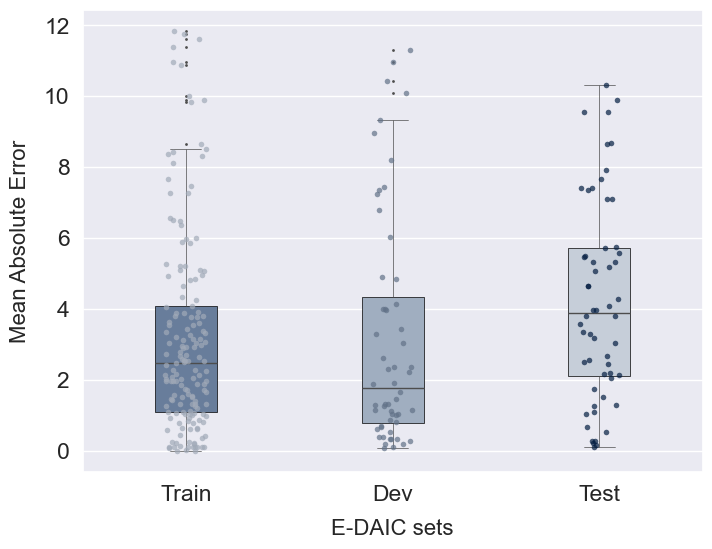

In [16]:
import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr, kendalltau, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager
from fau_colors import cmaps

# Explicitly set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(context='notebook', style='darkgrid', font='Times New Roman', font_scale=1.5)

# sns.set_theme(font='Times New Roman')
# sns.set_context("notebook", font_scale=1.5)
# sns.set_style("darkgrid")

# Load the CSV files
df_dev_count = pd.read_csv("df_dev_Q10_org_count.csv")
df_train_count = pd.read_csv("df_train_Q10_org_count.csv")
df_test_count = pd.read_csv("df_test_Q10_org_count.csv")

# Training and Evaluating and Testing --> 11 questions 

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'


# scaler = MinMaxScaler()

def plot_mae_distribution(mae_train, mae_dev, mae_test, output_file='mae_distribution_boxplot_textual_features.pdf'):
    # Set font and style
    # sns.set_theme(font='Times New Roman')
    # sns.set_context("notebook", font_scale=1.5)
    # sns.set_style("whitegrid")

    sns.set_theme(font='Times New Roman')
    sns.set_context("notebook", font_scale=1.5)
    sns.set_style("darkgrid")

    # Create a DataFrame with MAE values and their corresponding data sets
    data = {
        'Data Set': ['Train'] * len(mae_train) + ['Dev'] * len(mae_dev) + ['Test'] * len(mae_test),
        'MAE': np.concatenate((mae_train, mae_dev, mae_test))
    }
    df = pd.DataFrame(data)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8, 6))

    palette=cmaps.fau_light
    # palette = sns.color_palette("Set4")

    # Create a box plot with Seaborn
    sns.boxplot(
        x='Data Set', y='MAE', data=df, ax=ax,
        palette=palette, width=0.3,
        flierprops={'marker': 'o', 'markersize': 1},
        boxprops={'linewidth': 0.5, 'edgecolor': 'black'},
        whiskerprops={'linewidth': 0.5, 'linestyle': '-'},
        capprops={'linewidth': 0.5, 'linestyle': '-'}
    )

    # strip_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
    strip_colors = [cmaps.fau_dark[2], cmaps.fau_dark[1], cmaps.fau_dark[0]]
    # Add strip plot for each category with different colors
    for i, category in enumerate(df['Data Set'].unique()):
        sns.stripplot(x='Data Set', y='MAE', data=df[df['Data Set'] == category], ax=ax, 
                    color=strip_colors[i], size=4, jitter=True, alpha=0.7)

    # sns.stripplot(
    #     x='Data Set', y='MAE', data=df, ax=ax,
    #     color='blue', size=4, jitter=True, alpha=0.6
    # )

    # # Add annotations for median values
    # medians = df.groupby(['Data Set'])['MAE'].median().values
    # for tick, median in enumerate(medians):
    #     ax.text(tick, median + 0.1, f'{median:.2f}', 
    #             horizontalalignment='center', size='small', color='k', weight='semibold')
    

    # Set title and labels
    ax.set_ylabel('Mean Absolute Error', fontsize=16)
    ax.set_xlabel('E-DAIC sets', fontsize=16)

    # Add space between axis labels and tick labels
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 10

    # Save the plot to a high-quality PDF file
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

    plt.show()
  

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_prompt4_merged(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
                # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)
                # df_test.drop(df_test[df_test['id'] == 640].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 638].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    # print('merged_df_dev: ', merged_df_dev)

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)

    # # Fit the scaler on training data and transform training data
    # additional_features_scaled_train = scaler.fit_transform(additional_features)
    # X_train = np.concatenate((X_train, additional_features_scaled_train), axis=1)

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

    # # Similarly, transform dev and test data
    # additional_features_scaled_dev = scaler.transform(additional_features_dev)
    # X_dev = np.concatenate((X_dev, additional_features_scaled_dev), axis=1)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)

    # additional_features_scaled_test = scaler.transform(additional_features_test)
    # X_test = np.concatenate((X_test, additional_features_scaled_test), axis=1)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # Define the SVR model with desired parameters
    # svr = SVR(kernel='rbf', C=1.0, gamma='scale')

    # Decrease regularization (increase C)
    # svr = SVR(kernel='rbf', C=10, gamma='scale')


    # Experiment with different gamma values
    # svr = SVR(kernel='rbf', C=1.0, gamma=0.1)

    # Use polynomial kernel with higher degree
    # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')

    svr = SVR(kernel='linear', C=1.0)       
    # linear got the best results: RMSE for dev:  4.226683361916052
    # MAE for dev:  3.1309911417118084; RMSE for test:  5.28695435148159
    # MAE for test:  4.1224257572210465
    # Results with considering id=347: RMSE for dev:  4.591909342724911
    # MAE for dev:  3.32649779679585
    # RMSE for test:  5.28695435148159
    # MAE for test:  4.1224257572210465
    
    # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')  # results not good
    # svr = SVR(kernel='sigmoid', C=1.0, gamma='scale')         # results not good

    # Train the SVR model on X_train and y_train
    svr.fit(X_train, y_train)

    # Predict on X_train and calculate the mean squared error and mean absolute error
    y_pred_train = svr.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print('RMSE for train: ', np.sqrt(mse_train))
    print('MAE for train: ', mae_train)

    print('SRV results based on fine-tuned DepRoberta model: ')

    # Predict on X_dev and calculate the mean squared error and mean absolute error
    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev: ', np.sqrt(mse_dev))
    print('MAE for dev: ', mae_dev)

    # Find indices where the predicted label differs by 10 from the true label in the dev set
    indices_dev = np.where(np.abs(y_dev - y_pred_dev) >= 10)[0]
    print("Indices in dev set where the predicted label differs by 10 or more from the true label:")
    print(indices_dev)
    for index in indices_dev:
        print("Index:", index, "\tTrue:", y_dev[index], "\tPredicted:", y_pred_dev[index])

    # Predict on X_test and calculate the mean squared error and mean absolute error
    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test: ', np.sqrt(mse_test))
    print('MAE for test: ', mae_test)

    # Find indices where the predicted label differs by 10 from the true label in the test set
    indices_test = np.where(np.abs(y_test - y_pred_test) >= 10)[0]
    print("Indices in test set where the predicted label differs by 10 or more from the true label:")
    print(indices_test)
    for index in indices_test:
        print("Index:", index, "\tTrue:", y_test[index], "\tPredicted:", y_pred_test[index])

    print("Test set:")
    for true, pred in zip(y_test, y_pred_test):
        print("True:", true, "\tPredicted:", pred)
    
    # # Calculate the difference in predicted PHQ scores for dev and test sets
    # df_dev_count['Difference in PHQ Score'] = abs(df_dev_count['PHQ_Score'] - y_pred_dev)
    # df_test_count['Difference in PHQ Score'] = abs(df_test_count['PHQ_Score'] - y_pred_test)

    # # Calculate the correlation coefficient between the difference in PHQ score and the counts
    # corr_dev_non_mentioned, _ = pearsonr(df_dev_count['Non Mentioned count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_non_mentioned, _ = pearsonr(df_test_count['Non Mentioned count'], df_test_count['Difference in PHQ Score'])

    # corr_dev_to_some_extent, _ = pearsonr(df_dev_count['To Some Extent count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_to_some_extent, _ = pearsonr(df_test_count['To Some Extent count'], df_test_count['Difference in PHQ Score'])

    # print("Correlation coefficient between Non Mentioned count and Difference in PHQ Score (Dev):", corr_dev_non_mentioned)
    # print("Correlation coefficient between Non Mentioned count and Difference in PHQ Score (Test):", corr_test_non_mentioned)

    # print("Correlation coefficient between To Some Extent count and Difference in PHQ Score (Dev):", corr_dev_to_some_extent)
    # print("Correlation coefficient between To Some Extent count and Difference in PHQ Score (Test):", corr_test_to_some_extent)

    #     # Calculate the correlation coefficient using Spearman's rank correlation
    # corr_dev_non_mentioned_spearman, _ = spearmanr(df_dev_count['Non Mentioned count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_non_mentioned_spearman, _ = spearmanr(df_test_count['Non Mentioned count'], df_test_count['Difference in PHQ Score'])

    # corr_dev_to_some_extent_spearman, _ = spearmanr(df_dev_count['To Some Extent count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_to_some_extent_spearman, _ = spearmanr(df_test_count['To Some Extent count'], df_test_count['Difference in PHQ Score'])

    # print("Spearman's rank correlation coefficient between Non Mentioned count and Difference in PHQ Score (Dev):", corr_dev_non_mentioned_spearman)
    # print("Spearman's rank correlation coefficient between Non Mentioned count and Difference in PHQ Score (Test):", corr_test_non_mentioned_spearman)

    # print("Spearman's rank correlation coefficient between To Some Extent count and Difference in PHQ Score (Dev):", corr_dev_to_some_extent_spearman)
    # print("Spearman's rank correlation coefficient between To Some Extent count and Difference in PHQ Score (Test):", corr_test_to_some_extent_spearman)

    # # Calculate the correlation coefficient using Kendall's tau
    # corr_dev_non_mentioned_kendall, _ = kendalltau(df_dev_count['Non Mentioned count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_non_mentioned_kendall, _ = kendalltau(df_test_count['Non Mentioned count'], df_test_count['Difference in PHQ Score'])

    # corr_dev_to_some_extent_kendall, _ = kendalltau(df_dev_count['To Some Extent count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_to_some_extent_kendall, _ = kendalltau(df_test_count['To Some Extent count'], df_test_count['Difference in PHQ Score'])

    # print("Kendall's tau correlation coefficient between Non Mentioned count and Difference in PHQ Score (Dev):", corr_dev_non_mentioned_kendall)
    # print("Kendall's tau correlation coefficient between Non Mentioned count and Difference in PHQ Score (Test):", corr_test_non_mentioned_kendall)

    # print("Kendall's tau correlation coefficient between To Some Extent count and Difference in PHQ Score (Dev):", corr_dev_to_some_extent_kendall)
    # print("Kendall's tau correlation coefficient between To Some Extent count and Difference in PHQ Score (Test):", corr_test_to_some_extent_kendall)

    # # Calculate the correlation coefficient using point-biserial correlation
    # corr_dev_non_mentioned_pointbiserial, _ = pointbiserialr(df_dev_count['Non Mentioned count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_non_mentioned_pointbiserial, _ = pointbiserialr(df_test_count['Non Mentioned count'], df_test_count['Difference in PHQ Score'])

    # corr_dev_to_some_extent_pointbiserial, _ = pointbiserialr(df_dev_count['To Some Extent count'], df_dev_count['Difference in PHQ Score'])
    # corr_test_to_some_extent_pointbiserial, _ = pointbiserialr(df_test_count['To Some Extent count'], df_test_count['Difference in PHQ Score'])

    # print("Point-biserial correlation coefficient between Non Mentioned count and Difference in PHQ Score (Dev):", corr_dev_non_mentioned_pointbiserial)
    # print("Point-biserial correlation coefficient between Non Mentioned count and Difference in PHQ Score (Test):", corr_test_non_mentioned_pointbiserial)

    # print("Point-biserial correlation coefficient between To Some Extent count and Difference in PHQ Score (Dev):", corr_dev_to_some_extent_pointbiserial)
    # print("Point-biserial correlation coefficient between To Some Extent count and Difference in PHQ Score (Test):", corr_test_to_some_extent_pointbiserial)

    y_true_train = np.array(merged_df_train['PHQ_Score'])
    y_pred_train = svr.predict(X_train)
    mae_train = np.abs(y_true_train - y_pred_train)

    y_true_dev = np.array(merged_df_dev['PHQ_Score'])
    y_pred_dev = svr.predict(X_dev)
    mae_dev = np.abs(y_true_dev - y_pred_dev)

    y_true_test = np.array(merged_df_test['PHQ_Score'])
    y_pred_test = svr.predict(X_test)
    mae_test = np.abs(y_true_test - y_pred_test)

    plot_mae_distribution(mae_train, mae_dev, mae_test)
    

# ML_model_prompt4_merged('prompt1', 'org', features_directory_org)
# ML_model_prompt4_merged('prompt2', 'org', features_directory_org)
ML_model_prompt4_merged('prompt3', 'org', features_directory_org)

# ML_model_prompt4_merged('prompt1', 'revised', features_directory_revised)
# ML_model_prompt4_merged('prompt2', 'revised', features_directory_revised)
# ML_model_prompt4_merged('prompt3', 'revised', features_directory_revised)


# ==========================================================================================================================
# This is the best result which has been reported for the model based on the textual features (deproberta and 11 questions). 
# ==========================================================================================================================


In [79]:
# Performing cross validation as a response to the reviewer
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Training and Evaluating and Testing --> 11 questions 

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_prompt4_merged(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # Combine tarin and dev
    X_train_dev = np.concatenate((X_train, X_dev), axis=0)
    X = X_train_dev
    # Combine labels
    y_train_dev = np.concatenate((y_train, y_dev), axis=0)
    y = y_train_dev

    # Print the shapes to verify
    print("Combined X shape:", X_train_dev.shape)
    print("Combined y shape:", y_train_dev.shape)

    # Define the SVR model
    svr = SVR()

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.1, 0.01]
    }

    # Define the outer cross-validation on train + dev sets
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    best_model = None
    best_mae = float('inf')
    
    # Outer cross-validation loop
    for train_idx, dev_idx in outer_cv.split(X):
        # Split the data into train and dev sets
        X_train, X_dev = X[train_idx], X[dev_idx]
        y_train, y_dev = y[train_idx], y[dev_idx]

        # Inner cross-validation for hyperparameter tuning
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get the best model from the inner cross-validation
        model = grid_search.best_estimator_

        # Validate on the dev set
        y_pred_dev = model.predict(X_dev)
        mae_dev = mean_absolute_error(y_dev, y_pred_dev)
        print(f"MAE on dev set: {mae_dev}")
        mse_dev = mean_squared_error(y_dev, y_pred_dev)
        print(f"RMSE on dev set: {np.sqrt(mse_dev)}")

        # Keep track of the best model based on dev set performance
        if mae_dev < best_mae:
            best_mae = mae_dev
            best_model = model
    
    print("Best model hyperparameters:", best_model.get_params())

    # Evaluate the best model on the test set
    y_pred_dev = best_model.predict(X_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    print('Final Evaluation of the best model on dev Set - RMSE:', np.sqrt(mse_dev))
    print('Final Evaluation of the best model on dev Set - MAE:', mae_dev)

    # Evaluate the best model on the test set
    y_pred_test = best_model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('Final Evaluation on Test Set - RMSE:', np.sqrt(mse_test))
    print('Final Evaluation on Test Set - MAE:', mae_test)

ML_model_prompt4_merged('prompt3', 'org', features_directory_org)


# ==========================================================================================================================
# This is the best result which has been reported for the model based on the textual features (deproberta and 11 questions). 
# ==========================================================================================================================




prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train shape:  (163, 14)
X_dev shape:  (56, 14)
X_test shape:  (56, 14)
Combined X shape: (219, 14)
Combined y shape: (219,)
MAE on dev set: 3.8080974131622707
RMSE on dev set: 5.087801842391459
MAE on dev set: 3.539414521012448
RMSE on dev set: 4.687064021846449
MAE on dev set: 3.1970090172324763
RMSE on dev set: 3.8822452505785714
MAE on dev set: 3.1009910147135744
RMSE on dev set: 4.4139794683195905
MAE on dev set: 3.2819260146868645
RMSE on dev set: 4.452441185410034
Best model hyperparameters: {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Final Evaluation of the best model on dev Set - RMSE: 4.100599450533561
Final Evaluation of the best model on dev Set - MAE: 2.783855434442188
Final Evaluation on Test Set - RMSE: 5.465800575389462
Final Evaluation on Test

In [13]:
# import os
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, Dataset, TensorDataset
# from transformers import AdamW, GPT2TokenizerFast, AutoModel
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sentence_transformers import SentenceTransformer

# # Set up device (GPU or CPU)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# data_dir_org = '/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/original_transcripts_completions/'
# data_dir_revised = '/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/revised_transcripts_completions/'

# # Define a function to map PHQ scores to categories
# def map_phq_score_to_category(score):
#     if score >= 14:
#         # "severe" group
#         return 0
#     elif score >= 7 and score <= 13:
#         # "moderate" group
#         return 1
#     elif score < 7:
#         # "not depression" group
#         return 2

# def map_phq_score_for_all_prompts(prompt, org_or_revised_dir):
#     df_dev = pd.DataFrame()
#     df_train = pd.DataFrame()
#     df_test = pd.DataFrame()
#     folder_path = os.path.join(org_or_revised_dir, prompt)
#     print('folder_path: ', folder_path)
    
#     csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
#     print('csv_files: ', csv_files)

#     for file in csv_files:
#         file_path = os.path.join(folder_path, file)
#         if 'train' in file:
#             df_train = pd.read_csv(file_path)
#         elif 'dev' in file:
#             df_dev = pd.read_csv(file_path)
#             # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
#         elif 'test' in file:
#             df_test = pd.read_csv(file_path)
                
#     # Add a new column based on the PHQ scores
#     df_train["PHQ_Group"] = df_train["PHQ_Score"].apply(map_phq_score_to_category)
#     df_dev["PHQ_Group"] = df_dev["PHQ_Score"].apply(map_phq_score_to_category)
#     df_test["PHQ_Group"] = df_test["PHQ_Score"].apply(map_phq_score_to_category)

#     return (df_train, df_dev, df_test)


# # Fine tuning Deproberta
# model_dir = '/home/woody/empk/empk004h/models/fine_tuned_deproberta/'

# # Define a function for fine-tuning the deproberta model on a specific training set
# def fine_tune_deproberta_model(prompt, train_texts, train_labels, dev_texts, dev_labels, max_epochs=20):
    
#     tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")
#     model = AutoModelForSequenceClassification.from_pretrained("rafalposwiata/deproberta-large-depression", num_labels=3)
#     model.to(device)

#     # Prepare the data for the current training set
#     train_encodings = tokenizer(train_texts, truncation=True, padding=True)
#     train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), 
#                                   torch.tensor(train_encodings['attention_mask']),
#                                   torch.tensor(train_labels))

#     dev_encodings = tokenizer(dev_texts, truncation=True, padding=True)
#     dev_dataset = TensorDataset(torch.tensor(dev_encodings['input_ids']), 
#                                 torch.tensor(dev_encodings['attention_mask']),
#                                 torch.tensor(dev_labels))
#     dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)

#     # Define optimizer and other fine-tuning parameters here
#     # optim = torch.optim.AdamW(model.parameters(), lr=5e-6) #=> 68% accuracy on dev & 61% accuracy on test
#     # optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
#     # optim = torch.optim.AdamW(model.classifier.parameters(), lr=5e-6) # for fine-tuning only the final layer 
#     # optim = torch.optim.AdamW(model.classifier.out_proj.parameters(), lr=5e-6) # for fine-tuning last 2 fully connected layers

#     # for param in model.base_model.parameters():
#     #     param.requires_grad = False

#     # for param in model.classifier.dense.parameters():   # for fine-tuning last 2 fully connected layers
#     #     param.requires_grad = False

#     # for name, param in model.named_parameters():
#     #     if 'classifier' not in name:  # Unfreeze classifier layer
#     #         param.requires_grad = False


#     # Unfreeze the last 4 layers of the base model's encoder
#     for name, param in model.named_parameters():
#         if 'classifier' not in name and 'encoder.layer' in name:
#             layer_num = int(name.split('encoder.layer.')[-1].split('.')[0])
#             if layer_num >= (model.config.num_hidden_layers - 4):  # Unfreeze last 4 layers
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = False
    
#     optim = torch.optim.AdamW(
#     [
#         {'params': model.classifier.parameters()},
#         {'params': model.base_model.encoder.layer[-10:].parameters(), 'lr': 1e-5}  # Fine-tuning last 4 layers
#     ],
#     lr=5e-6
#     )
    
#     # Define the scheduler
#     # scheduler = CosineAnnealingLR(optim, T_max=5, eta_min=1e-7)

#     # Parameters for early stopping
#     best_dev_loss = float('inf')  # Track the best development loss
#     best_epoch = -1  # Track the epoch with the best development loss
#     epochs_since_best_loss = 0  # Count the number of epochs since the best loss was updated
#     max_epochs_without_improvement = 3  # Number of epochs without improvement to trigger early stopping

#     # Train the model
#     train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

#     # Start fine-tuning
#     for epoch in range(max_epochs):
#         model.train() 
#         print('len train_loader: ', len(train_loader))
#         for step, batch in enumerate(train_loader):
#             optim.zero_grad()
#             input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)
#             outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
#             loss = outputs.loss
#             loss.backward()
#             optim.step()
#             # scheduler.step()
            
#             current_lr = optim.param_groups[0]['lr']
#             print(f"Epoch {epoch}, Batch {step}, Learning Rate: {current_lr:.8f}, Train Loss: {loss.item():.3f}")
            
#             # if step % 100 == 0:
#             #     print(f"Epoch {epoch}, Batch {step}, Train Loss: {loss.item():.3f}")
            
#         # Calculate dev loss after each epoch
#         model.eval()
#         dev_loss = 0
#         dev_total = 0
#         dev_predictions = []
#         dev_targets = []
#         with torch.no_grad():
#             for dev_batch in dev_loader:
#                 dev_input_ids, dev_attn_mask, dev_labels = tuple(t.to(device) for t in dev_batch)
#                 dev_outputs = model(dev_input_ids, attention_mask=dev_attn_mask, labels=dev_labels)
#                 dev_loss += dev_outputs.loss.item() * dev_labels.size(0)
#                 dev_total += dev_labels.size(0)

#                 # Compute predictions for accuracy calculation
#                 logits = dev_outputs.logits
#                 predictions = torch.argmax(logits, dim=1)
#                 dev_predictions.extend(predictions.cpu().numpy())
#                 dev_targets.extend(dev_labels.cpu().numpy())

#             dev_avg_loss = dev_loss / dev_total
#             dev_accuracy = accuracy_score(dev_targets, dev_predictions)
#             print(f"Epoch {epoch}, Dev Loss: {dev_avg_loss:.3f}, Dev Accuracy: {dev_accuracy:.3f}")

#             # # Check for early stopping
#             # if dev_avg_loss < best_dev_loss:
#             #     best_dev_loss = dev_avg_loss
#             #     best_epoch = epoch  # Update the best epoch
#             #     print('best_epoch: ', best_epoch)
#             #     epochs_since_best_loss = 0

#             #     # Update the best model's state dict
#             #     best_model_state_dict = model.state_dict()
                
#             #     # Save the model at the best epoch
#             #     model_name = f"fine_tuned_model_prompt_{result['prompt_number']}_best_epoch_{best_epoch}"
#             #     model.save_pretrained(model_dir + model_name)
#             #     print("The best model has been saved!")
#             # else:
#             #     epochs_since_best_loss += 1
                
#         # print('epochs_since_best_loss: ', epochs_since_best_loss)
#         # if epochs_since_best_loss >= max_epochs_without_improvement:
#         #     print("Early stopping triggered. No improvement in dev loss.")
#         #     break
                               
#         # Create the folder named according to the prompt
#         prompt_folder = os.path.join(model_dir, prompt)
#         os.makedirs(prompt_folder, exist_ok=True)

#         # Save the model inside the prompt folder
#         model_name = f"fine_tuned_deproberta_model_epoch_{epoch}"
#         model.save_pretrained(prompt_folder)

#     return model

# def fine_tune_deproberta_model_all_prompts(prompt, org_or_revised_dir):
#     df_train, df_dev, df_test = map_phq_score_for_all_prompts(prompt, org_or_revised_dir)
#     train_texts = df_train['completions'].tolist()
#     train_labels = np.array(df_train['PHQ_Group'].tolist())
#     dev_texts = df_dev['completions'].tolist()
#     dev_labels = np.array(df_dev['PHQ_Group'].tolist())

#     max_epochs = 20
#     model = fine_tune_deproberta_model(prompt, train_texts, train_labels, dev_texts, dev_labels, max_epochs)


# fine_tune_deproberta_model_all_prompts('prompt_1', data_dir_org)
# fine_tune_deproberta_model_all_prompts('prompt_2', data_dir_org)
# fine_tune_deproberta_model_all_prompts('prompt_3', data_dir_org)

# fine_tune_deproberta_model_all_prompts('prompt_1', data_dir_revised)
# fine_tune_deproberta_model_all_prompts('prompt_2', data_dir_revised)
# fine_tune_deproberta_model_all_prompts('prompt_3', data_dir_revised)

# # best_model_state_dict = None
# # print('best_model_state_dict: ', best_model_state_dict)
# # if best_model_state_dict is not None:
# #     # Save the fine-tuned model
# #     model_name = f"fine_tuned_model_prompt_{result['prompt_number']}"
# #     model.load_state_dict(best_model_state_dict)
# #     model.save_pretrained(model_dir + model_name)
# #     print("The model has been saved!")


In [65]:
# Feature extraction based on fine-tuned deproberta (new fine-tuned models based on each prompt's completions)
# Extracting deproberta features (probabilities) from completions for all of the prompts results

import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AdamW, GPT2TokenizerFast, AutoModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from torch.optim.lr_scheduler import CosineAnnealingLR
from sentence_transformers import SentenceTransformer
from transformers import AutoConfig

# def extract_features(prompt, df):

#     # # Remove newlines and non-meaningful characters
#     # df['completions'] = df['completions'].replace(r'\n', ' ', regex=True)  # Replace newlines with spaces
#     # df['completions'] = df['completions'].replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Remove non-alphanumeric and non-space characters
#     # df['completions'] = df['completions'].replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space


#     # Specify the local directory path containing the model files
#     model_dir = "./fine_tuned_deproberta_models/fine_tuned_deproberta_model_epoch_14/"

#     models_dir = "./fine_tuned_deproberta_models"
#     # models_dir = "./fine_tuned_deproberta_models/best_deproberta_finetuned_train_3rd_phq_range_12_ep_lr_5e-6/"
#     model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    
#     tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")

#     # if 'prompt1' in prompt:
#     #     print('prompt: ', prompt)
#     #     print('prompt1')
#     #     # Load the latest fine-tuned Deproberta model
#     #     mode_dir = os.path.join(models_dir, 'prompt_1')
#     #     model = AutoModelForSequenceClassification.from_pretrained(mode_dir)
#     # elif 'prompt2' in prompt:
#     #     print('prompt: ', prompt)
#     #     print('prompt2')
#     #     # Load the latest fine-tuned Deproberta model
#     #     mode_dir = os.path.join(models_dir, 'prompt_2')
#     #     model = AutoModelForSequenceClassification.from_pretrained(mode_dir)
#     # elif 'prompt3' in prompt:
#     #     print('prompt: ', prompt)
#     #     print('prompt3')
#     #     # Load the latest fine-tuned Deproberta model
#     #     mode_dir = os.path.join(models_dir, 'prompt_3')
#     #     model = AutoModelForSequenceClassification.from_pretrained(mode_dir)

#     X = df['completions']
#     # X = df['text']
#     print('len X: ', len(X))

#     # Extract features
#     X_features = []
#     for i in range(len(X)):
#         input_ids = torch.tensor(tokenizer.encode(X[i], add_special_tokens=True)).unsqueeze(0)  # Batch size 1
#         outputs = model(input_ids)
#         logits = outputs[0]
#         probs = torch.softmax(logits, dim=1)
#         predicted_label_index = torch.argmax(probs, dim=1).item()
#         X_features.append(probs.detach().numpy())

#     return X_features

def extract_features(prompt, df):
    model_dir = "./fine_tuned_deproberta_models/fine_tuned_deproberta_model_epoch_14/"
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")

    X = df['text']
    print('len X:', len(X))

    X_features = []
    for i in range(len(X)):
        # Tokenize with truncation and padding
        inputs = tokenizer(
            X[i], 
            return_tensors='pt', 
            max_length=512,   # Maximum length for RoBERTa models
            truncation=True,  # Truncate if the text is too long
            padding='max_length'  # Pad to max length if shorter
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
        
        X_features.append(probs.squeeze(0).detach().numpy())

    return X_features

def extract_features_for_all_dfs(dataframes_dict):
    for key, df in dataframes_dict.items():
        if 'Q10' not in key:
            print('name of the df: ', key)
            print(df.head())
            features = extract_features(key, df)  
            df['features_deproberta'] = features
            # print('df after feature extraction: ', df.head())
    
    return dataframes_dict

# Function to read CSV files and store them in dataframes
def read_csv_files(directory):
    dfs = {}  # Dictionary to store dataframes
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                filepath = os.path.join(root, file)
                df_name = os.path.splitext(file)[0]  # Extract dataframe name from file name
                dfs[df_name] = pd.read_csv(filepath)  # Store dataframe in dictionary

    return dfs

# Reading generated CSV files for 4 new prompts and creating corresponding dataframes
# data_path = '../data/'
data_path = './deproberta_features_fine_tuned_mode_based_on_prompts'

# Read CSV files from original_transcripts_completions directory
# original_dfs = read_csv_files(os.path.join(data_path, 'original_transcripts_completions'))
original_dfs = read_csv_files(os.path.join(data_path, 'original'))

# Read CSV files from revised_transcripts_completions directory
# revised_dfs = read_csv_files(os.path.join(data_path, 'revised_transcripts_completions'))
revised_dfs = read_csv_files(os.path.join(data_path, 'revised'))

# print('df_dev_prompt1\n', original_dfs['df_dev_prompt1'].head())
print('Original transcripts keys:', original_dfs.keys())
print('Revised transcripts keys:', revised_dfs.keys())

# print('Original transcripts df_train_prompt1: ', original_dfs['df_train_prompt1'].head())
print('max PHQ score in df_train_prompt1: ', max(original_dfs['df_train_prompt1']['PHQ_Score']))

# Update original transcripts dataframes with extracted features
original_dfs_with_features = extract_features_for_all_dfs(original_dfs)

# Update revised transcripts dataframes with extracted features
revised_dfs_with_features = extract_features_for_all_dfs(revised_dfs)

def save_dataframes_to_csv(dataframes_dict, directory):
    for key, df in dataframes_dict.items():
        filename = os.path.join(directory, f"{key}.csv")
        df.to_csv(filename, index=False)
        print(f"DataFrame '{key}' saved to '{filename}'")

# output_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
# output_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

output_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts_bypass_gpt/original/'
output_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts_bypass_gpt/revised/'

# Save original transcripts dataframes with extracted features
save_dataframes_to_csv(original_dfs_with_features, output_directory_org)

# Save revised transcripts dataframes with extracted features
save_dataframes_to_csv(revised_dfs_with_features, output_directory_revised)

Original transcripts keys: dict_keys(['df_dev_prompt3_revised', 'df_dev_Q10_revised', 'df_test_prompt3_revised', 'df_train_prompt1', 'df_train_prompt3', 'df_train_Q10', 'df_train_prompt2', 'df_test_prompt2', 'df_dev_prompt2', 'df_test_prompt1', 'df_dev_prompt1', 'df_test_Q10_revised'])
Revised transcripts keys: dict_keys(['df_dev_Q10', 'df_test_Q10', 'df_train_prompt1', 'df_train_prompt3', 'df_train_Q10', 'df_train_prompt2', 'df_test_prompt2', 'df_dev_prompt3', 'df_dev_prompt2', 'df_test_prompt3', 'df_test_prompt1', 'df_dev_prompt1'])
max PHQ score in df_train_prompt1:  23
name of the df:  df_dev_prompt3_revised
    id  Gender  PHQ_Binary  PHQ_Score  PCL-C (PTSD)  PTSD Severity  \
0  300    male           0          2             0             25   
1  301    male           0          3             0             17   
2  306  female           0          0             0             21   
3  317    male           0          8             1             51   
4  320  female           0    

In [17]:
# Audio quality check 
import os
import numpy as np
import librosa
import wave

# Path to the directory containing audio files
audio_files_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/audio"

def calculate_RMS(signal):
    return np.sqrt(np.mean(signal ** 2))

# Dictionary to store filename and corresponding RMS energy
rms_energy_dict = {}
SNR_dict = {}
Frequency_spectrum_dict = {}

for filename in os.listdir(audio_files_path):
    if filename.endswith(".wav"):
        audio_file_path = os.path.join(audio_files_path, filename)
        # print("Processing:", audio_file_path)

        # # Load audio file using wave library to get metadata
        # with wave.open(audio_file_path, 'rb') as wav_file:
        #     num_channels = wav_file.getnchannels()
        #     sample_width = wav_file.getsampwidth()
        #     sample_rate = wav_file.getframerate()
        #     print(f"Metadata: Channels={num_channels}, Sample Width={sample_width}, Sample Rate={sample_rate} Hz")

        # Load audio file
        y, sr = librosa.load(audio_file_path, sr=None)

        # Calculate RMS enery
        # Calculate RMS energy
        rms_energy = calculate_RMS(y)
        # Store filename and RMS energy in the dictionary
        rms_energy_dict[filename] = rms_energy

        # Calculate SNR
        noise_floor = 10 * np.log10(np.mean(y ** 2))
        signal_power = 10 * np.log10(np.max(y ** 2))
        snr = signal_power - noise_floor
        # print(f"SNR: {snr:.2f} dB")
        SNR_dict[filename] = snr

        # Calculate frequency spectrum
        X = librosa.stft(y)
        Xdb = librosa.amplitude_to_db(X)
        # print(f"Frequency spectrum: {Xdb.shape[1]} Hz")
        Frequency_spectrum_dict[filename] = Xdb.shape[1]


# Sort the dictionary based on RMS energy values
sorted_rms_energy_dict = sorted(rms_energy_dict.items(), key=lambda x: x[1])
sorted_SNR_dict = sorted(SNR_dict.items(), key=lambda x: x[1])
sorted_Frequency_spectrum_dict = sorted(Frequency_spectrum_dict.items(), key=lambda x: x[1])
        

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_3709/1316700508.py:48: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  Xdb = librosa.amplitude_to_db(X)


In [18]:
# Print the sorted filenames and corresponding RMS energy
for filename, rms_energy in sorted_rms_energy_dict:
    print("Filename:", filename, "| RMS Energy:", rms_energy)

for filename, SNR in sorted_SNR_dict:
    print("Filename:", filename, "| SNR:", SNR)

for filename, Frequency_spectrum in sorted_Frequency_spectrum_dict:
    print("Filename:", filename, "| Frequency_spectrum:", Frequency_spectrum)


Filename: 607_AUDIO.wav | RMS Energy: 0.0015051636
Filename: 436_AUDIO.wav | RMS Energy: 0.0017056386
Filename: 624_AUDIO.wav | RMS Energy: 0.0017650747
Filename: 635_AUDIO.wav | RMS Energy: 0.0018437777
Filename: 479_AUDIO.wav | RMS Energy: 0.0020386388
Filename: 343_AUDIO.wav | RMS Energy: 0.002077432
Filename: 459_AUDIO.wav | RMS Energy: 0.0021714587
Filename: 655_AUDIO.wav | RMS Energy: 0.0022502835
Filename: 461_AUDIO.wav | RMS Energy: 0.0022629297
Filename: 476_AUDIO.wav | RMS Energy: 0.0022951036
Filename: 431_AUDIO.wav | RMS Energy: 0.0023124402
Filename: 716_AUDIO.wav | RMS Energy: 0.0023426593
Filename: 354_AUDIO.wav | RMS Energy: 0.0024198922
Filename: 658_AUDIO.wav | RMS Energy: 0.0024305996
Filename: 609_AUDIO.wav | RMS Energy: 0.0024767674
Filename: 435_AUDIO.wav | RMS Energy: 0.0027260112
Filename: 600_AUDIO.wav | RMS Energy: 0.0027786081
Filename: 427_AUDIO.wav | RMS Energy: 0.0028189658
Filename: 673_AUDIO.wav | RMS Energy: 0.0028249468
Filename: 677_AUDIO.wav | RMS En

In [114]:
# import os
# import numpy as np
# from scipy.stats import pearsonr
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, mean_absolute_error


# # Training and Evaluating and Testing based on the new extracted features 
# # from deproberta model fine-tuned on each prompt

# features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
# features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# # Function to convert string representation to NumPy array
# def str_to_np_array(s):
#     s = s.strip('[]')  # Remove square brackets
#     return np.fromstring(s, sep = ' ')

# def ML_model_each_prompt(prompt, org_or_revised_dir):
#     print('prompt: ', prompt)
#     print('org_or_revised_dir: ', org_or_revised_dir)

#     df_dev = pd.DataFrame()
#     df_train = pd.DataFrame()
#     df_test = pd.DataFrame()
#     csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
#     for file in csv_files:
#         file_path = os.path.join(org_or_revised_dir, file)
#         if prompt in file:
#             if 'train' in file:
#                 df_train = pd.read_csv(file_path)
#             elif 'dev' in file:
#                 df_dev = pd.read_csv(file_path)
#                 # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
#                 # df_dev.drop(df_dev[df_dev['id'] == 321].index, inplace=True)
#                 # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
#                 # df_dev.drop(df_dev[df_dev['id'] == 441].index, inplace=True)
#                 # df_dev.drop(df_dev[df_dev['id'] == 698].index, inplace=True)
#             elif 'test' in file:
#                 df_test = pd.read_csv(file_path)
#                 # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)
#                 # df_test.drop(df_test[df_test['id'] == 649].index, inplace=True)
#                 # df_test.drop(df_test[df_test['id'] == 661].index, inplace=True)
#                 # df_test.drop(df_test[df_test['id'] == 705].index, inplace=True)
#                 # also check 604, 638, 640 in the test set

#     # Convert string representation of list to actual list using ast.literal_eval
#     df_train['features_deproberta'] = df_train['features_deproberta'].apply(str_to_np_array)
#     df_dev['features_deproberta'] = df_dev['features_deproberta'].apply(str_to_np_array)
#     df_test['features_deproberta'] = df_test['features_deproberta'].apply(str_to_np_array)

#     df_train['features_deproberta'] = df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
#     df_dev['features_deproberta'] = df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
#     df_test['features_deproberta'] = df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

#     # # Print the shape of each array in the 'features_deproberta' column
#     # for i, array in enumerate(df_train['features_deproberta']):
#     #     shape = array.shape
#     #     # print(f"Shape of row {i} in 'features_deproberta' column: {shape}")

#     # X_train = np.array(df_train['features_deproberta'])
#     # X_dev = np.array(df_dev['features_deproberta'])
#     # X_test = np.array(df_test['features_deproberta'])

#     X_train = np.array([x.reshape(3) for x in df_train['features_deproberta']])
#     X_dev = np.array([x.reshape(3) for x in df_dev['features_deproberta']])
#     X_test = np.array([x.reshape(3) for x in df_test['features_deproberta']])

#     # print('X_train shape: ', X_train.shape)
#     # print('X_dev shape: ', X_dev.shape)
#     # print('X_test shape: ', X_test.shape)

#     y_train = np.array(df_train['PHQ_Score'])
#     y_dev = np.array(df_dev['PHQ_Score'])
#     y_test = np.array(df_test['PHQ_Score'])

#     # print('y_train shape: ', y_train.shape)
#     # print('y_dev shape: ', y_dev.shape)
#     # print('y_test shape: ', y_test.shape)

#     # print(X_train)
#     # print(y_train)

#     # # Define the parameter grid for GridSearchCV
#     # param_grid = {
#     #     'kernel': ['linear', 'rbf', 'poly'],
#     #     'C': [0.01, 0.1, 10],
#     #     'gamma': ['scale', 'auto'],
#     #     'coef0': [0.0, 1.0, 2.0],
#     #     'degree': [2, 3]
#     # }

#     # Define the SVR model with desired parameters
#     # svr = SVR(kernel='rbf', C=1.0, gamma='scale')

#     # Decrease regularization (increase C)
#     # svr = SVR(kernel='rbf', C=10, gamma='scale')


#     # Experiment with different gamma values
#     svr = SVR(kernel='rbf', C=1.0, gamma=0.1)

#     # Use polynomial kernel with higher degree
#     # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')

#     # svr = SVR(kernel='linear', C=1.0)
#     # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')
#     # svr = SVR(kernel='sigmoid', C=1.0, gamma='scale')

#     # Train the SVR model on X_train and y_train
#     svr.fit(X_train, y_train)

#     # # Perform grid search to find the best parameters
#     # grid_search = GridSearchCV(SVR(), param_grid, cv=5)
#     # grid_search.fit(X_train, y_train)

#     # # Get the best SVR model from the grid search
#     # svr = grid_search.best_estimator_

#     # # Get the best parameters found by grid search
#     # best_params = grid_search.best_params_
#     # print("Best parameters found by grid search:")
#     # print(best_params)

#     # Train the SVR model on X_train and y_train
#     # svr.fit(X_train, y_train)

#     # Predict on X_train and calculate the mean squared error and mean absolute error
#     y_pred_train = svr.predict(X_train)
#     mse_train = mean_squared_error(y_train, y_pred_train)
#     mae_train = mean_absolute_error(y_train, y_pred_train)
#     print('RMSE for train: ', np.sqrt(mse_train))
#     print('MAE for train: ', mae_train)

#     print('SRV results based on fine-tuned DepRoberta model: ')

#     # # Print predicted and true values for train set
#     # print("Train set:")
#     # for true, pred in zip(y_train, y_pred_train):
#     #     print("True:", true, "\tPredicted:", pred)

#     # Predict on X_dev and calculate the mean squared error and mean absolute error
#     y_pred_dev = svr.predict(X_dev)
#     mse_dev = mean_squared_error(y_dev, y_pred_dev)
#     mae_dev = mean_absolute_error(y_dev, y_pred_dev)
#     print('RMSE for dev: ', np.sqrt(mse_dev))
#     print('MAE for dev: ', mae_dev)

#     # Print predicted and true values for dev set
#     # print("Dev set:")
#     # for true, pred in zip(y_dev, y_pred_dev):
#     #     print("True:", true, "\tPredicted:", pred)
#     print('-----------------------------------')

#     # # Checking to see if there is correlation between the audio quality and the predicted labels
#     # # Predict on X_test and calculate the mean squared error and mean absolute error
#     # y_pred_test = svr.predict(X_test)
#     # mse_test = mean_squared_error(y_test, y_pred_test)
#     # mae_test = mean_absolute_error(y_test, y_pred_test)
#     # print('RMSE for test: ', np.sqrt(mse_test))
#     # print('MAE for test: ', mae_test)

#     # # Collect the absolute differences between true and predicted PHQ scores for dev and test sets
#     # absolute_diff_dev = np.abs(y_dev - y_pred_dev)
#     # absolute_diff_test = np.abs(y_test - y_pred_test)

#     # # Collect the audio quality metrics for dev and test sets
#     # audio_quality_metrics_dev = []
#     # audio_quality_metrics_test = []

#     # for index, row in df_dev.iterrows():
#     #     participant_id = str(row['id'])
#     #     participant_id_key = participant_id + '_AUDIO.wav'
#     #     rms_energy = rms_energy_dict.get(participant_id_key)
#     #     SNR = SNR_dict.get(participant_id_key)
#     #     Frequency_spectrum = Frequency_spectrum_dict.get(participant_id_key)
#     #     audio_quality_metrics_dev.append((rms_energy, SNR, Frequency_spectrum))

#     # for index, row in df_test.iterrows():
#     #     participant_id = str(row['id'])
#     #     participant_id_key = participant_id + '_AUDIO.wav'
#     #     rms_energy = rms_energy_dict.get(participant_id_key)
#     #     SNR = SNR_dict.get(participant_id_key)
#     #     Frequency_spectrum = Frequency_spectrum_dict.get(participant_id_key)
#     #     audio_quality_metrics_test.append((rms_energy, SNR, Frequency_spectrum))

#     # # Calculate correlations between audio quality metrics and absolute differences for dev and test sets
#     # correlations_dev = []
#     # correlations_test = []

#     # for i in range(len(audio_quality_metrics_dev[0])):
#     #     print("i:", i)
#     #     metric_values_dev = [sample[i] for sample in audio_quality_metrics_dev]
#     #     print(metric_values_dev)
#     #     correlation_dev, _ = pearsonr(metric_values_dev, absolute_diff_dev)
#     #     correlations_dev.append(correlation_dev)

#     # for i in range(len(audio_quality_metrics_test[0])):
#     #     metric_values_test = [sample[i] for sample in audio_quality_metrics_test]
#     #     correlation_test, _ = pearsonr(metric_values_test, absolute_diff_test)
#     #     correlations_test.append(correlation_test)

#     # # Print correlations for dev and test sets
#     # print("Correlations between audio quality metrics and absolute differences for dev set:")
#     # print("RMS Energy:", correlations_dev[0])
#     # print("SNR:", correlations_dev[1])
#     # print("Frequency Spectrum:", correlations_dev[2])
#     # print()

#     # print("Correlations between audio quality metrics and absolute differences for test set:")
#     # print("RMS Energy:", correlations_test[0])
#     # print("SNR:", correlations_test[1])
#     # print("Frequency Spectrum:", correlations_test[2])
#     # print()

#     # Find indices where the predicted label differs by 10 from the true label in the dev set
#     indices_dev = np.where(np.abs(y_dev - y_pred_dev) >= 10)[0]
#     print("Indices in dev set where the predicted label differs by 10 or more from the true label:")
#     print(indices_dev)
#     for index in indices_dev:
#         print("Index:", index, "\tTrue:", y_dev[index], "\tPredicted:", y_pred_dev[index]) 

#     # Predict on X_test and calculate the mean squared error and mean absolute error
#     y_pred_test = svr.predict(X_test)
#     mse_test = mean_squared_error(y_test, y_pred_test)
#     mae_test = mean_absolute_error(y_test, y_pred_test)
#     print('RMSE for test: ', np.sqrt(mse_test))
#     print('MAE for test: ', mae_test)

#     # Print predicted and true values for test set
#     # print("Test set:")
#     # for true, pred in zip(y_test, y_pred_test):
#     #     print("True:", true, "\tPredicted:", pred)
#     print('-----------------------------------')

#     # Find indices where the predicted label differs by 10 from the true label in the dev set
#     indices_test = np.where(np.abs(y_test - y_pred_test) >= 10)[0]
#     print("Indices in test set where the predicted label differs by 10 or more from the true label:")
#     print(indices_test)
#     for index in indices_test:
#         print("Index:", index, "\tTrue:", y_test[index], "\tPredicted:", y_pred_test[index]) 

#     # # Iterate through the dataframes to access IDs and corresponding predictions
#     # for dataframe, dataset_name, y_pred in zip([df_dev, df_test], ['Dev', 'Test'], [y_pred_dev, y_pred_test]):
#     #     for index, row in dataframe.iterrows():
#     #         participant_id = str(row['id'])  # Extracting the first 3 digits as participant ID
#     #         print("participant_id: ", participant_id)

#     #         participant_id_key = participant_id + "" + '_AUDIO.wav'
#     #         print("participant_id_key: ", participant_id_key)

#     #         # Retrieve corresponding audio quality check results
#     #         rms_energy = rms_energy_dict.get(participant_id_key)
#     #         SNR = SNR_dict.get(participant_id_key)
#     #         Frequency_spectrum = Frequency_spectrum_dict.get(participant_id_key)

#     #         # Print audio quality check results along with predicted PHQ score
#     #         print(f"{dataset_name} set - Participant ID: {participant_id}")
#     #         print("RMS Energy:", rms_energy)
#     #         print("SNR:", SNR)
#     #         print("Frequency Spectrum:", Frequency_spectrum)
#     #         print("True PHQ Score:", row['PHQ_Score'])
#     #         print("Predicted PHQ Score:", y_pred[index])
#     #         print("-------------------------------")

# ML_model_each_prompt('prompt1', features_directory_org)
# ML_model_each_prompt('prompt2', features_directory_org)
# ML_model_each_prompt('prompt3', features_directory_org)

# ML_model_each_prompt('prompt1', features_directory_revised)
# ML_model_each_prompt('prompt2', features_directory_revised)
# ML_model_each_prompt('prompt3', features_directory_revised)



In [62]:
# Feature extraction based on fine-tuned deproberta only for one completion

import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AdamW, GPT2TokenizerFast, AutoModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from torch.optim.lr_scheduler import CosineAnnealingLR
from sentence_transformers import SentenceTransformer

def extract_features(text):

    # models_dir = "./fine_tuned_deproberta_models"
    # models_dir = "./fine_tuned_deproberta_models/best_deproberta_finetuned_train_3rd_phq_range_12_ep_lr_5e-6/"
   
    tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")
    model = AutoModelForSequenceClassification.from_pretrained("rafalposwiata/deproberta-large-depression")
    # models_dir = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/NEW_Experiments/fine_tuned_deproberta_models/fine_tuned_deproberta_model_epoch_14-6"
    # model = AutoModelForSequenceClassification.from_pretrained("/Users/misha/My_Projects/DAIC_Depression/depression-detection/NEW_Experiments/fine_tuned_deproberta_models/fine_tuned_deproberta_model_epoch_14-6")
    # tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")

    # Extract features
    X_features = []
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
    outputs = model(input_ids)
    logits = outputs[0]
    probs = torch.softmax(logits, dim=1)
    predicted_label_index = torch.argmax(probs, dim=1).item()
    X_features.append(probs.detach().numpy())

    return X_features


text = """ 
The interviewee is from Sweden. The interviewee discussed their background in early childhood education and their desire to work with children as a school teacher. They expressed a close relationship with their family and shared their struggles with the passing of their mother, which has triggered feelings of sadness and depression. The interviewee mentioned feeling down frequently and struggling with stability in their job situation in California. They also discussed their coping mechanisms for dealing with their emotions and memories of their mother, as well as their ability to control their temper. Additionally, the interviewee shared positive experiences, such as celebrating a family member's birthday and traveling to Memphis to visit family and friends. Throughout the interview, the interviewee expressed a mix of emotions, including happiness, sadness, and resilience in the face of challenges.
"""

print(extract_features(text))

[array([[0.03095802, 0.20973054, 0.7593114 ]], dtype=float32)]


In [117]:
# [array([[0.03683992, 0.23901026, 0.7241498 ]], dtype=float32)]

In [118]:
# from scipy.stats import f_oneway

# # Data
# probabilities = {
#     "Female": [0.6804368043290141],
#     "Non-Binary": [0.6838588062378588],
#     "Genderqueer": [0.6899234944996765],
#     "Genderfluid": [0.6869971160471411],
#     "Agender": [0.6853213475687674],
#     "Bigender": [0.6816177169127225],
#     "Demiboy": [0.6890375910987604],
#     "Demigirl": [0.7014412826329639],
#     "Two-Spirit": [0.6728631706097371],
#     "Androgynous": [0.6738433543732322]
# }

# # Perform ANOVA
# f_statistic, p_value = f_oneway(*probabilities.values())

# print("F-Statistic:", f_statistic)
# print("P-Value:", p_value)

In [119]:
# # Feature extraction based on the original deproberta for the interviews with added biases

# import os
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, Dataset, TensorDataset
# from transformers import AdamW, GPT2TokenizerFast, AutoModel
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sentence_transformers import SentenceTransformer

# text = """ 
#  Okay, there you go. So if you can just move around a little bit for me so that the Xbox can connect. There we go. Perfect. Okay. When you're finished, you can go ahead and ring the doorbell. And you can go ahead and go to the women whenever she's done. Hi, I'm Ellie. Thanks for coming in today. I was created to talk to people in a safe and secure environment. Think of me as a friend. I don't judge. I can't. I'm a computer. I'm here to learn about people and would love to learn about you. I'll ask a few questions to get us started. And please feel free to tell me anything. Your answers are totally confidential. How are you doing today? I'm fine. How about yourself? I'm great. Thanks. Where are you from originally? From Los Angeles, California. Really? Me too. What part? Why don't we talk about our labor? Okay. What are some things you really like about LA? All my family's here. Friends. A mixture of people and a lot of things to do. Okay. What did you study at school? Early childhood education. Nice. Are you still working in that? No, not right now. But I would love to get back into it. Why? I love working with kids and seeing them smile. Tell me more about that. I guess it goes back to when I was a kid. I liked being happy and playful. So I guess it just transferred to my adult life. What's your dream job? What's your dream job? Working with kids as a school teacher. Or in that capacity. That sounds really hard. Yeah it is, but if it's a passion of yours, it would always be fine. That's great. How close are you to your family? Very close. Sometimes too close. Can you give me an example of that? I have four sisters and one brother on my mom's side. And on my dad's I have six brothers and four sisters. And we are intertwined together. That's why I say we're too close sometimes. I see what you mean. Do you consider yourself an introvert? No. Why? I have a lot of friends that I interact with and we're always doing different things. So that's why I say I'm not. Okay. What do you do when you're annoyed? Curse. Curse? Mm-hmm. Just let it out. Okay. When was the last time you argued with someone and what was it about? A couple days ago. My nephew didn't call me back. How did you feel in that moment? Kind of mad because I had set aside some time to spend with him and he just blew it off and didn't call me back. Yeah. That sucks. Yeah, I know. How are you at controlling your temper? I'm okay. Okay. Hmm. What's one of your most memorable experiences? When my mother passed. I'm sorry. Tell me more about that. It's been about five years now to the day. So it's getting better. Time makes it easier. That's good. Do you feel down? A lot. Because there's a lot of things that make me think about her on a daily basis. Yeah. Like what? Anything. Driving by a particular restaurant that she likes. Watching different TV shows. Just anything that could trigger a memory of my mom. Yeah. When was the last time it happened? Yesterday. Hmm. How do you cope with them? I think about the good times and don't stay in that place too long. Just go ahead and think about it and move on. Yeah. Have you been diagnosed with depression? Hmm. Not officially, but I think I might be depressed. Tell me more about that. Well, since my mom passed, it's been kind of rough. And then the job situation is not stable here in California. So that has a lot to do with it as well. That sounds really hard. Yeah, it is. Have you ever seen any changes in her behavior? Some sort of changes to myself. Reserved. Mm-hmm. Do you have disturbing thoughts? Not really. Okay. How easy is it for you to get a good night's sleep? It's pretty easy. What are you like when you don't sleep well? Grumpy, irritable, fidgety, big ball of nerves. Hmm. Do you travel a lot? What do you mean? Whatever comes to your mind. I guess so, yeah. I like to travel. What do you enjoy about traveling? Meeting new people, different locations, scenery, different opportunities to try something new in a new location. Awesome. I'd love to hear about all your trips. I just came back from Memphis about three weeks ago. I went to see family and friends. It was pretty nice. I got a chance to see something new. Change the scenery. Yeah. What advice would you give yourself ten or twenty years ago? Wow. Stick to the plan and don't veer off to the left or right. Just go straight ahead. What made you decide to do that? Just different circumstances in life that gradually pushed me towards the left and the right. There are always tradeoffs in life, aren't there? Every day. Is there anything you regret? A few relationships, not staying in school, missing out on great opportunities with employers. How would your best friend describe you? Funny, loyal, spontaneous, life of the party. How do you know them? Grew up together in the same community. Went to school together, high school friends. Who's someone that's been a positive influence in your life? My big sister, Michelle. My friend, Troy. I mean, there's others, but those two, no matter good or bad, they're always in my corner for me. Yeah. That's so good to hear. Thank you. When was the last time you were really happy? Yesterday. Celebrated his birthday. Aww. That's great. I'd love to hear all about it. It was just a little small intimate setting. Cooked a meal, had family and friends over. Listened to music, watched a movie, talked about the old days when my mom was here and when we were all one unit. So it was just a nice evening. Yeah. That's good. Okay, I think I've asked everything I need to. Thanks for sharing your thoughts with me. Thank you. Goodbye. Bye-bye. Bye. Was the screen like that the whole time? While I was talking. It was? Oh my gosh. I'm sorry. That's very bizarre. I've never seen you do that before. Have to do it over? No.
# """
# # Extract features
# X_features = []
# input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
# outputs = model(input_ids)
# logits = outputs[0]
# probs = torch.softmax(logits, dim=1)
# predicted_label_index = torch.argmax(probs, dim=1).item()
# X_features.append(probs.detach().numpy())

# print(X_features)

In [120]:
# # Feature extraction based on fine-tuned deproberta only for one completion

# import os
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader, Dataset, TensorDataset
# from transformers import AdamW, GPT2TokenizerFast, AutoModel
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sentence_transformers import SentenceTransformer

# def extract_features(text):

#     # models_dir = "./fine_tuned_deproberta_models"
#     # models_dir = "./fine_tuned_deproberta_models/best_deproberta_finetuned_train_3rd_phq_range_12_ep_lr_5e-6/"
#     models_dir = "./fine_tuned_deproberta_models/fine_tuned_deproberta_model_epoch_14-6/"
#     model = AutoModelForSequenceClassification.from_pretrained(models_dir)
#     tokenizer = AutoTokenizer.from_pretrained("rafalposwiata/deproberta-large-depression")

#     # Extract features
#     X_features = []
#     input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
#     outputs = model(input_ids)
#     logits = outputs[0]
#     probs = torch.softmax(logits, dim=1)
#     predicted_label_index = torch.argmax(probs, dim=1).item()
#     X_features.append(probs.detach().numpy())

#     return X_features


# text = """ 

# Based on the interview, here are the main points concerning the interviewee's mental health:

# Emotional Response to Loss: The interviewee recently experienced the death of their uncle, which has made them feel sad. They express difficulty in coping, particularly because their family is spread out, making it hard to be together during this time.

# Difficulty Expressing Emotions: The interviewee admits to struggling with expressing their emotions openly, particularly during difficult times like mourning a loss. They tend to keep their feelings inside and may find it challenging to talk about their emotions with others.

# Sleep Patterns and Irritability: The interviewee mentions that irregular work hours make it difficult for them to maintain a consistent sleep schedule. When they don't sleep well, they become more irritable and grumpy, suggesting a potential impact on their mood and well-being.

# Positive Influences: The interviewee acknowledges their father as a positive influence in their life, indicating a supportive familial relationship that provides stability and guidance.

# Coping Mechanisms: Despite facing challenges, the interviewee employs techniques to relax and manage their emotions, such as watching movies, spending time with their dog, and completing projects that provide a sense of accomplishment.

# No Diagnosed Mental Health Conditions: The interviewee states that they have not been diagnosed with depression, anxiety, or PTSD, suggesting that they may not have sought professional mental health evaluation or treatment for any underlying issues.
# """

# print(extract_features(text))

In [17]:
# Merge visual and text features for multi-modal prediction
import os
# import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
# from torchviz import make_dot
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class PHQDataset(Dataset):
    def __init__(self, csv_file, data_folder, max_seq_length=None, feature_type=None):
        self.data_folder = data_folder
        self.data_info = pd.read_csv(csv_file)
        self.max_seq_length = max_seq_length
        self.feature_type = feature_type
        self.scaler = StandardScaler()

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        participant_id = self.data_info.iloc[idx]['Participant_ID']
        phq_score = self.data_info.iloc[idx]['PHQ_Score']
        filepath = os.path.join(self.data_folder, f"{participant_id}_OpenFace2.1.0_Pose_gaze_AUs.csv")
        features_df = pd.read_csv(filepath)
        features_df = features_df.iloc[:, 2:]  # Remove the first two columns (frame and timestamp)
        # features = pd.read_csv(filepath).to_numpy()
        # features = features[:, 2:] # Remove the first two features (frame and timestamp)

        # Define column sets
        pose_columns = [col for col in features_df.columns if col.startswith('pose_')]
        gaze_columns = [col for col in features_df.columns if col.startswith('gaze_')]
        au_r_columns = [col for col in features_df.columns if col.endswith('_r')]
        au_c_columns = [col for col in features_df.columns if col.endswith('_c')]

        # Select columns based on feature type
        if self.feature_type == 'pose':
            selected_columns = pose_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze':
            selected_columns = gaze_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'au_r':
            selected_columns = au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'au_c':
            selected_columns = au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'confidence_success_pose':
            selected_columns = pose_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_gaze':
            selected_columns = gaze_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUintens':
            selected_columns = au_r_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUoccurr':
            selected_columns = au_c_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUoccurr_pose_gaze':
            selected_columns = au_c_columns + gaze_columns + pose_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUintens_pose_gaze':
            selected_columns = au_r_columns + gaze_columns + pose_columns + ['confidence', 'success']
        elif self.feature_type == 'pose_gaze':
            selected_columns = gaze_columns + pose_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_au_r':
            selected_columns = pose_columns + au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_au_c':
            selected_columns = pose_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze_au_r':
            selected_columns = gaze_columns + au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze_au_c':
            selected_columns = gaze_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'au_r_au_c':
            selected_columns = au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_gaze_au_r':
            selected_columns = pose_columns + gaze_columns + au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_gaze_au_c':
            selected_columns = pose_columns + gaze_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_au_r_au_c':
            selected_columns = pose_columns + au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze_au_r_au_c':
            selected_columns = gaze_columns + au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'all':
            selected_columns = pose_columns + gaze_columns + au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'confidence_success_all':
            selected_columns = None
        else:
            selected_columns = None  # Use all columns if feature_type is not recognized
        
        if selected_columns is not None:
            features_df = features_df[selected_columns]
            # Remove rows with NaN values
            features_df = features_df.dropna()
            features = features_df.values
        else:
            # Remove rows with NaN values
            features_df = features_df.dropna()
            features = features_df.values
        
        # Apply feature normalization
        # features_normalized = self.scaler.fit_transform(features)
        # print("features_normalized shape: ", features_normalized.shape)

        # if self.max_seq_length is not None:
        #     padded_features = np.zeros((self.max_seq_length, features_normalized.shape[1]))
        #     padded_features[:features_normalized.shape[0], :features_normalized.shape[1]] = features_normalized
        #     features_normalized = padded_features

        # print('features.shape at the end: ', features.shape)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(phq_score, dtype=torch.float32)
        # return torch.tensor(features_normalized, dtype=torch.float32), torch.tensor(phq_score, dtype=torch.float32)

class Attention(nn.Module):
    def __init__(self, feature_dim, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.proj = nn.Linear(feature_dim, 64)
        self.context_vector = nn.Linear(64, 1, bias=False)

    def forward(self, x):
        x_proj = torch.tanh(self.proj(x))
        context_vector = self.context_vector(x_proj).squeeze(2)
        attention_weights = torch.softmax(context_vector, dim=1)
        weighted = torch.mul(x, attention_weights.unsqueeze(-1).expand_as(x))
        return torch.sum(weighted, dim=1)
    
# class EnhancedPHQLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=2, dropout_rate=0.5):
#         super(EnhancedPHQLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
#                             batch_first=True, bidirectional=True, dropout=dropout_rate)
#         self.attention = Attention(hidden_size * 2)
#         self.fc = nn.Linear(hidden_size * 2, 1)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         attn_out = self.attention(lstm_out)
#         # final_output = self.fc(lstm_out[:, -1, :])  # Taking the last output of the sequence to check the performance without attention layer
#         final_output = self.fc(attn_out)
#         return final_output

class EnhancedPHQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout_rate=0.5):
        super(EnhancedPHQLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.attention = Attention(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 128)  # Adjust the output size of the fully connected layer

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        return attn_out  # Return the output of the attention layer

    def get_last_fc_output(self, x):
        lstm_out, _ = self.lstm(x)
        # print("Shape of lstm_out:", lstm_out.shape)
        attn_out = self.attention(lstm_out)
        # print("Shape of attn_out:", attn_out.shape)
        fc_out = self.fc(attn_out)
        # print("Shape of fc_out:", fc_out.shape)
        
        # final_output_a = self.fc(lstm_out[:, -1, :]) 
        # print("Shape of final_output_a:", final_output_a.shape)
        # final_output_b = self.fc(attn_out)
        # print("Shape of final_output_b:", final_output_b.shape)
        # return fc_out
        return attn_out

criterion = nn.MSELoss()
mae = nn.L1Loss()

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_stack = torch.stack(yy, dim=0)
    return xx_pad, yy_stack, x_lens

# Define different combinations of feature types
feature_combinations = ['all', 'pose','gaze','au_r','au_c', \
                        'pose_gaze', 'pose_au_r', 'pose_au_c', \
                        'gaze_au_r', 'gaze_au_c', \
                        'au_r_au_c', \
                        'pose_gaze_au_r', 'pose_gaze_au_c', 'pose_au_r_au_c', 'gaze_au_r_au_c', \
                        'confidence_success_all', \
                        'confidence_success_AUintens', 'confidence_success_AUoccurr', \
                        'confidence_success_pose','confidence_success_gaze', \
                        'confidence_success_AUintens_pose_gaze', \
                        'confidence_success_AUoccurr_pose_gaze']


openface_data_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/DAIC_openface_features/"
labels_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/labels/"

# Read labels
train_labels = pd.read_csv(os.path.join(labels_path, 'train_split.csv'))
dev_labels = pd.read_csv(os.path.join(labels_path, 'dev_split.csv'))
test_labels = pd.read_csv(os.path.join(labels_path, 'test_split.csv'))

# Convert labels to NumPy arrays
train_ids = train_labels['Participant_ID'].values
dev_ids = dev_labels['Participant_ID'].values
test_ids = test_labels['Participant_ID'].values

train_data_path = os.path.join(openface_data_path, "train")
dev_data_path = os.path.join(openface_data_path, "dev")
test_data_path = os.path.join(openface_data_path, "test")

train_dataset = PHQDataset(os.path.join(labels_path, 'train_split.csv'), train_data_path, feature_type="pose_gaze_au_r")
dev_dataset = PHQDataset(os.path.join(labels_path, 'dev_split.csv'), dev_data_path, feature_type="pose_gaze_au_r")
test_dataset = PHQDataset(os.path.join(labels_path, 'test_split.csv'), test_data_path, feature_type="pose_gaze_au_r")

# Load the pretrained model
model_path = "lstm_model_pose_gaze_au_r.pth"
pretrained_model = torch.load(model_path, map_location=torch.device('cpu'))

print("Model layers:")
for name, layer in pretrained_model.named_children():
    print(name, layer)

# Function to extract features from a dataset using the pretrained model
def extract_features_from_dataset(model, dataset):
    i = 0
    extracted_features = []
    model.eval()
    with torch.no_grad():
        for features, phq_scores in dataset:
            # print("features: ", features)
            # print("phq_scores: ", phq_scores)
            # print("i: ", i)
            features = features.unsqueeze(0).to(device)  # Add batch dimension if needed
            output = model.get_last_fc_output(features).squeeze().cpu().numpy()  # Get output from last fully connected layer
            # print("output shape: ", output.shape)
            extracted_features.append(output)
            i += 1
    return extracted_features


# # Extract features from train, test, and dev sets
train_features = extract_features_from_dataset(pretrained_model, train_dataset)
test_features = extract_features_from_dataset(pretrained_model, test_dataset)
dev_features = extract_features_from_dataset(pretrained_model, dev_dataset)

# Now train_features, test_features, and dev_features contain the extracted features for the respective datasets

# ================================================================================================================
# This is the code where we use the final trained LSTM model (lstm_model_pose_gaze_au_r.pth) to extract features.
# ================================================================================================================


Using device: cpu
Model layers:
lstm LSTM(31, 64, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
attention Attention(
  (proj): Linear(in_features=128, out_features=64, bias=True)
  (context_vector): Linear(in_features=64, out_features=1, bias=False)
)
fc Linear(in_features=128, out_features=1, bias=True)


/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/785773046.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load(model_path, map

In [121]:
# import torch
# import os
# import pandas as pd
# from torch.utils.data import DataLoader

# # Define the PHQDataset and DataLoader
# test_data_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/DAIC_openface_features/test"
# labels_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/labels/"
# test_dataset = PHQDataset(os.path.join(labels_path, 'test_split.csv'), test_data_path, feature_type="pose_gaze_au_r")
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=pad_collate)

# model_path = "lstm_model_pose_gaze_au_r.pth"

# # Function to predict PHQ scores from the saved model
# def predict_phq_scores_from_saved_model(model_path, dataloader):
#     # Load the pretrained model
#     input_size = 31 
#     hidden_size = 64 
#     pretrained_model = EnhancedPHQLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=3, dropout_rate=0.3).to(device)
#     pretrained_model = torch.load(model_path, map_location=torch.device('cpu'))
#     pretrained_model.eval()

#     all_predictions = []
#     all_actuals = []

#     with torch.no_grad():
#         for i, (features, phq_scores, _) in enumerate(dataloader):
#             features = features.float().to(device)  # Convert features to Float and move to device
#             phq_scores = phq_scores.float().to(device)
#             # print("phq_scores: ", phq_scores)
#             outputs = pretrained_model(features).squeeze()
#             # print("outputs: ", outputs)

#             # Print phq_scores, outputs, and IDs for each sample
#             for phq, output in zip(phq_scores, outputs):
#                 print(f"Test Set - ID: {i}, PHQ Score: {phq.item()}, Predicted Output: {output.item()}")


#             # # Check if outputs is a single value or a sequence
#             # if outputs.dim() == 0:
#             #     all_predictions.append(outputs.item())
#             #     all_actuals.append(phq_scores.item())
#             #     print(f"Test Set - ID: {i}, Predicted PHQ Score: {outputs.item():.4f}, Actual PHQ Score: {phq_scores.item():.4f}")
#             # else:
#             #     for j, output in enumerate(outputs):
#             #         all_predictions.append(output.item())
#             #         all_actuals.append(phq_scores[j].item())
#             #         print(f"Test Set - ID: {i}, Sequence ID: {j}, Predicted PHQ Score: {output.item():.4f}, Actual PHQ Score: {phq_scores[j].item():.4f}")

#     return all_predictions, all_actuals

# # Predict PHQ scores for the test set using the saved model
# test_phq_predictions, test_phq_actuals = predict_phq_scores_from_saved_model(model_path, test_loader)


In [19]:
test_features[0].shape


(128,)

In [ ]:
# features in lstm model

# confidence	success	pose_Tx	pose_Ty	pose_Tz	pose_Rx	pose_Ry	pose_Rz	gaze_0_x	gaze_0_y	gaze_0_z	gaze_1_x	gaze_1_y	gaze_1_z	gaze_angle_x	gaze_angle_y	AU01_r	AU02_r	AU04_r	AU05_r	AU06_r	AU07_r	AU09_r	AU10_r	AU12_r	AU14_r	AU15_r	AU17_r	AU20_r	AU23_r	AU25_r	AU26_r	AU45_r

'Times New Roman' is available.
prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train before:  [[0.05349561 0.41876933 0.52773505 ... 0.51190476 0.         0.27956989]
 [0.01334761 0.06639707 0.92025536 ... 0.5        0.         0.        ]
 [0.01617503 0.16090362 0.82292134 ... 1.         0.         0.        ]
 ...
 [0.0191604  0.14461505 0.8362245  ... 0.         0.         1.        ]
 [0.54851735 0.42541996 0.02606268 ... 0.5        0.5        1.        ]
 [0.07291351 0.13164644 0.79544014 ... 0.5        0.5        1.        ]]
train_features_array:  [[ 2.4439606e-33 -9.9996197e-01  1.1578738e-21 ...  9.9996197e-01
   2.8647964e-09 -1.8460708e-13]
 [ 1.5638487e-33 -9.9996090e-01  8.1788129e-22 ...  9.9996090e-01
   2.7321834e-09 -1.4574638e-13]
 [ 2.2526314e-33 -9.9996221e-01  1.0826594e-21 ...  9.9996221e-01
   2.8400953e-09 -1.7599390e-13]
 ...
 [ 2.3576528e-33 -9.9996215e-01  1.1252419e-21 ...  9.9996209e-01
   2.8532847e

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/57738769.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_4979/57738769.py:66: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(


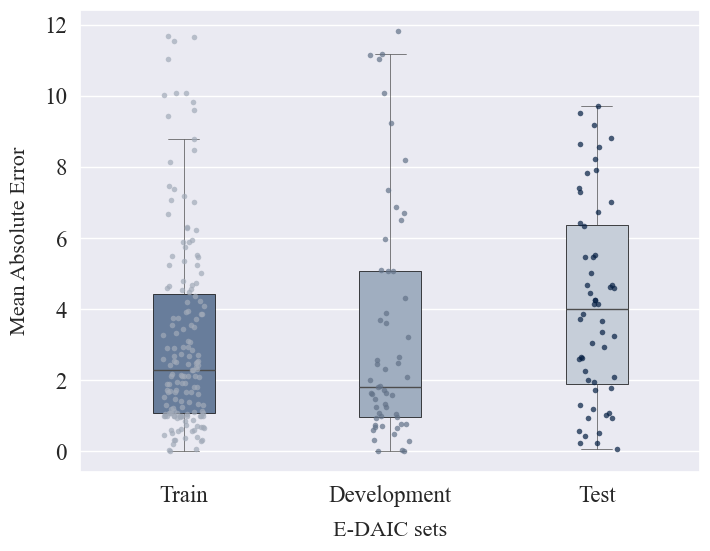

In [24]:
# Training and Evaluating and Testing a Multimodal Model 

import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager
from fau_colors import cmaps
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager

# Check if 'Times New Roman' is available
available_fonts = [f.name for f in font_manager.fontManager.ttflist]
if 'Times New Roman' not in available_fonts:
    print("Warning: 'Times New Roman' is not available on this system.")
else:
    print("'Times New Roman' is available.")

# Set the font globally for matplotlib
plt.rcParams['font.family'] = 'Times New Roman'

# Set the font for seaborn
sns.set_theme()
sns.set_context("notebook", font_scale=1.5)
sns.set_style("darkgrid", {'font.family': 'Times New Roman'})

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# sns.set_theme(font='Times New Roman')
# sns.set_context("notebook", font_scale=1.5)
# sns.set_style("darkgrid")

def plot_mae_distribution(mae_train, mae_dev, mae_test, output_file='mae_distribution_boxplot_multimodal_features.pdf'):
    # Create a DataFrame with MAE values and their corresponding data sets
    data = {
        'Data Set': ['Train'] * len(mae_train) + ['Development'] * len(mae_dev) + ['Test'] * len(mae_test),
        'MAE': np.concatenate((mae_train, mae_dev, mae_test))
    }
    
    df = pd.DataFrame(data)

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8, 6))

    palette=cmaps.fau_light
    # palette = sns.color_palette("Set4")

    # Create a box plot with Seaborn
    sns.boxplot(
        x='Data Set', y='MAE', data=df, ax=ax,
        palette=palette, width=0.3,
        # flierprops={'marker': 'o', 'markersize': 1},
        showfliers=False,
        boxprops={'linewidth': 0.5, 'edgecolor': 'black'},
        whiskerprops={'linewidth': 0.5, 'linestyle': '-'},
        capprops={'linewidth': 0.5, 'linestyle': '-'}
    )

    # strip_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
    strip_colors = [cmaps.fau_dark[2], cmaps.fau_dark[1], cmaps.fau_dark[0]]
    # Add strip plot for each category with different colors
    for i, category in enumerate(df['Data Set'].unique()):
        sns.stripplot(x='Data Set', y='MAE', data=df[df['Data Set'] == category], ax=ax, 
                    color=strip_colors[i], size=4, jitter=True, alpha=0.7)
        
    # Set title and labels
    ax.set_ylabel('Mean Absolute Error', fontsize=16)
    ax.set_xlabel('E-DAIC sets', fontsize=16)

    # Add space between axis labels and tick labels
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 10

    # Save the plot to a high-quality PDF file
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_text_visual(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
                # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)
                # df_test.drop(df_test[df_test['id'] == 640].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 638].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)
    print('X_train before: ', X_train)

    # Convert train_features to a single numpy array
    train_features_array = np.vstack(train_features)        # These are the LSTM features
    print('train_features_array: ', train_features_array)

    # Define PCA with desired number of components for LSTM features
    pca_lstm = PCA(n_components=10)
    # Fit PCA to LSTM features
    pca_lstm.fit(train_features_array)
    # Transform LSTM features
    train_features_array_pca = pca_lstm.transform(train_features_array)
    # Merge LSTM features with text features
    X_train = np.concatenate((X_train, train_features_array_pca), axis=1)
    print("Shape of X_train_merged after PCA:", X_train.shape)

    # Similarly, perform PCA transformation on dev and test LSTM features and merge them with respective additional features

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

    dev_features_array = np.vstack(dev_features)

    dev_features_array_pca = pca_lstm.transform(dev_features_array)
    X_dev = np.concatenate((X_dev, dev_features_array_pca), axis=1)
    print("Shape of X_dev_merged after PCA:", X_dev.shape)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)

    test_features_array = np.vstack(test_features)

    test_features_array_pca = pca_lstm.transform(test_features_array)
    X_test = np.concatenate((X_test, test_features_array_pca), axis=1)
    print("Shape of X_test_merged after PCA:", X_test.shape)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

     # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon parameter
    }

    # Instantiate SVR
    svr = SVR(kernel='rbf')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV to your data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    print("Best params:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # svr = SVR(kernel='linear', C=1.0)  
    svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1) 
    # svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=1)   
    svr.fit(X_train, y_train)

    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev= mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev (PCA): ', np.sqrt(mse_dev))
    print('MAE for dev (PCA): ', mae_dev)

    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test (PCA): ', np.sqrt(mse_test))
    print('MAE for test (PCA): ', mae_test)

# --------

    # # Merge train_features_array with X_train
    # X_train = np.concatenate((X_train, train_features_array), axis=1)
    # print("Shape of X_train_merged:", X_train.shape)

    # # Similarly for dev and test sets
    # additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

    # dev_features_array = np.vstack(dev_features)
    # X_dev = np.concatenate((X_dev, dev_features_array), axis=1)
    # print("Shape of X_dev_merged:", X_dev.shape)

    # additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # X_test = np.concatenate((X_test, additional_features_test), axis=1)

    # test_features_array = np.vstack(test_features)
    # X_test = np.concatenate((X_test, test_features_array), axis=1)
    # print("Shape of X_test_merged:", X_test.shape)

    # print('X_train shape: ', X_train.shape)
    # print('X_dev shape: ', X_dev.shape)
    # print('X_test shape: ', X_test.shape)

    # y_train = np.array(merged_df_train['PHQ_Score'])
    # y_dev = np.array(merged_df_dev['PHQ_Score'])
    # y_test = np.array(merged_df_test['PHQ_Score'])

    # -------

    # param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
    # grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
    # grid_search.fit(X_train, y_train)
    # print("Best params:", grid_search.best_params_)
    # print("Best score:", grid_search.best_score_)
    
    # reg = RandomForestRegressor()
    # reg.fit(X_train, y_train)

    # importances = permutation_importance(reg, X_train, y_train, n_repeats=10, random_state=42)
    # print("Feature importances:", importances)

    # reg_pipeline = Pipeline([
    #     ('feature_selection', SelectFromModel(RandomForestRegressor(max_depth=5, n_estimators=50))),
    #     ('regression', RandomForestRegressor(max_depth=5, n_estimators=50))
    # ])

    # # Fit the pipeline to your data
    # reg_pipeline.fit(X_train, y_train)

    # # Evaluate on development set
    # y_pred_dev = reg_pipeline.predict(X_dev)
    # mse_dev = mean_squared_error(y_dev, y_pred_dev)
    # mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    # print('RMSE for dev: ', np.sqrt(mse_dev))
    # print('MAE for dev: ', mae_dev)

    # # Evaluate on test set
    # y_pred_test = reg_pipeline.predict(X_test)
    # mse_test = mean_squared_error(y_test, y_pred_test)
    # mae_test = mean_absolute_error(y_test, y_pred_test)
    # print('RMSE for test: ', np.sqrt(mse_test))
    # print('MAE for test: ', mae_test)


    # # svr = SVR(kernel='linear', C=1.0)  
    # svr = SVR(kernel='rbf', C=1.0)  

    # Train the SVR model on X_train and y_train
    # svr.fit(X_train, y_train)

    # Perform feature selection using SelectKBest
    selector = SelectKBest(f_regression, k=10)  # Select top 10 features
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_dev_selected = selector.transform(X_dev)
    X_test_selected = selector.transform(X_test)

    print('X_train_selected shape: ', X_train_selected.shape)
    print('X_dev_selected shape: ', X_dev_selected.shape)
    print('X_test_selected shape: ', X_test_selected.shape)

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon parameter
    }

    # Instantiate SVR
    svr = SVR(kernel='rbf')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV to your data
    grid_search.fit(X_train_selected, y_train)

    # Get the best parameters
    print("Best params:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # svr = SVR(kernel='linear', C=1.0)  
    # svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1) 
    svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=1)   
    svr.fit(X_train_selected, y_train)

    y_pred_train_selected = svr.predict(X_train_selected)
    mse_train_selected = mean_squared_error(y_train, y_pred_train_selected)
    mae_train_selected = mean_absolute_error(y_train, y_pred_train_selected)
    print('RMSE for train (selected features): ', np.sqrt(mse_train_selected))
    print('MAE for train (selected features): ', mae_train_selected)

    y_pred_dev_selected = svr.predict(X_dev_selected)
    mse_dev_selected = mean_squared_error(y_dev, y_pred_dev_selected)
    mae_dev_selected = mean_absolute_error(y_dev, y_pred_dev_selected)
    print('RMSE for dev (selected features): ', np.sqrt(mse_dev_selected))
    print('MAE for dev (selected features): ', mae_dev_selected)

    y_pred_test_selected = svr.predict(X_test_selected)
    mse_test_selected = mean_squared_error(y_test, y_pred_test_selected)
    mae_test_selected = mean_absolute_error(y_test, y_pred_test_selected)
    print('RMSE for test (selected features): ', np.sqrt(mse_test_selected))
    print('MAE for test (selected features): ', mae_test_selected)

    # Calculate and store MAE for each prediction
    y_pred_train = svr.predict(X_train_selected)
    mae_train = np.abs(y_train - y_pred_train)

    y_pred_dev = svr.predict(X_dev_selected)
    mae_dev = np.abs(y_dev - y_pred_dev)

    y_pred_test = svr.predict(X_test_selected)
    mae_test = np.abs(y_test - y_pred_test)

    # MAE plot distribution (for multi modal model)
    plot_mae_distribution(mae_train, mae_dev, mae_test)

ML_model_text_visual('prompt3', 'org', features_directory_org)

# ===========================================================================================
# This is the best result which has been reported for the model based on multimodal features. 
# ===========================================================================================


In [89]:
# Training and Evaluating and Testing a Multimodal Model with nested cross val

import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_text_visual(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)

    # Convert train_features to a single numpy array
    train_features_array = np.vstack(train_features)        # These are the LSTM features

    # Define PCA with desired number of components for LSTM features
    pca_lstm = PCA(n_components=10)
    # Fit PCA to LSTM features
    pca_lstm.fit(train_features_array)
    # Transform LSTM features
    train_features_array_pca = pca_lstm.transform(train_features_array)
    # Merge LSTM features with text features
    X_train = np.concatenate((X_train, train_features_array_pca), axis=1)
    print("Shape of X_train_merged after PCA:", X_train.shape)

    # Similarly, perform PCA transformation on dev and test LSTM features and merge them with respective additional features

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)
    print("X_dev:", X_dev.shape)

    dev_features_array = np.vstack(dev_features)
    print("dev_features_array:", dev_features_array.shape)

    dev_features_array_pca = pca_lstm.transform(dev_features_array)
    X_dev = np.concatenate((X_dev, dev_features_array_pca), axis=1)
    print("Shape of X_dev_merged after PCA:", X_dev.shape)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)

    test_features_array = np.vstack(test_features)

    test_features_array_pca = pca_lstm.transform(test_features_array)
    X_test = np.concatenate((X_test, test_features_array_pca), axis=1)
    print("Shape of X_test_merged after PCA:", X_test.shape)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # Step 1: Apply PCA to reduce dimensionality
    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train)
    X_dev_pca = pca.transform(X_dev)
    X_test_pca = pca.transform(X_test)

    # Step 2: Apply SelectKBest for feature selection
    selector = SelectKBest(f_regression, k=10)
    X_train_selected = selector.fit_transform(X_train_pca, y_train)
    X_dev_selected = selector.transform(X_dev_pca)
    X_test_selected = selector.transform(X_test_pca)

    print(f"Shape after PCA and SelectKBest - X_train: {X_train_selected.shape}, X_dev: {X_dev_selected.shape}, X_test: {X_test_selected.shape}")

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5]  # Epsilon parameter
    }

    # Define the SVR model
    svr = SVR(kernel='rbf')

    # Define the outer cross-validation loop on train + dev sets
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    best_model = None
    best_mae_test = float('inf')
    
    mae_dev_list = []
    rmse_dev_list = []

    # Combine tarin and dev
    X_train_selected = np.concatenate((X_train_selected, X_dev_selected), axis=0)
    # Combine labels
    y_train = np.concatenate((y_train, y_dev), axis=0)

    # Print the shapes to verify
    print("Combined X shape:", X_train_selected.shape)
    print("Combined y shape:", y_train.shape)

    # Outer cross-validation loop
    for train_idx, dev_idx in outer_cv.split(X_train_selected):
        # Split the data into train and dev sets
        X_train_cv, X_dev_cv = X_train_selected[train_idx], X_train_selected[dev_idx]
        y_train_cv, y_dev_cv = y_train[train_idx], y_train[dev_idx]

        # Inner cross-validation loop for hyperparameter tuning
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train_cv, y_train_cv)

        # Get the best model from inner cross-validation
        model = grid_search.best_estimator_

        # Evaluate on the inner dev set
        y_pred_dev_cv = model.predict(X_dev_cv)
        mae_dev_cv = mean_absolute_error(y_dev_cv, y_pred_dev_cv)
        rmse_dev_cv = np.sqrt(mean_squared_error(y_dev_cv, y_pred_dev_cv))
        mae_dev_list.append(mae_dev_cv)
        rmse_dev_list.append(rmse_dev_cv)
    
    # Calculate mean performance metrics on the dev set
    mean_mae_dev = np.mean(mae_dev_list)
    mean_rmse_dev = np.mean(rmse_dev_list)
    print(f"Nested CV - Mean MAE on dev set: {mean_mae_dev:.4f}")
    print(f"Nested CV - Mean RMSE on dev set: {mean_rmse_dev:.4f}")

    # Train the best model on the full training data (train + dev)
    final_model = grid_search.best_estimator_
    final_model.fit(X_train_selected, y_train)

    # Evaluate the final model on the untouched test set
    y_pred_test = final_model.predict(X_test_selected)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"Final Evaluation on Test Set - MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")


ML_model_text_visual('prompt3', 'org', features_directory_org)

# ===========================================================================================
# This is the best result which has been reported for the model based on multimodal features. 
# ===========================================================================================


prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
Shape of X_train_merged after PCA: (163, 24)
X_dev: (56, 14)
dev_features_array: (56, 128)
Shape of X_dev_merged after PCA: (56, 24)
Shape of X_test_merged after PCA: (56, 24)
X_train shape:  (163, 24)
X_dev shape:  (56, 24)
X_test shape:  (56, 24)
Shape after PCA and SelectKBest - X_train: (163, 10), X_dev: (56, 10), X_test: (56, 10)
Combined X shape: (219, 10)
Combined y shape: (219,)
Nested CV - Mean MAE on dev set: 3.4179
Nested CV - Mean RMSE on dev set: 4.5422
Final Evaluation on Test Set - MAE: 4.2176, RMSE: 5.0831


In [21]:
# calculate feature importance for the model from the previous code cell. 
# everything is the same as the previous cell (only without the part for the plot),
# I just added the feature importance stuff. 

# Training and Evaluating and Testing a Multimodal Model 

import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager
from fau_colors import cmaps
import shap
from sklearn.preprocessing import StandardScaler

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_text_visual(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
                # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)
                # df_test.drop(df_test[df_test['id'] == 640].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 638].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)
    # print('X_train before: ', X_train)

    # Convert train_features to a single numpy array
    train_features_array = np.vstack(train_features)        # These are the LSTM features
    # print('train_features_array: ', train_features_array)

    # Define PCA with desired number of components for LSTM features
    pca_lstm = PCA(n_components=10)
    # Fit PCA to LSTM features
    pca_lstm.fit(train_features_array)
    # Transform LSTM features
    train_features_array_pca = pca_lstm.transform(train_features_array)
    # Merge LSTM features with text features
    X_train = np.concatenate((X_train, train_features_array_pca), axis=1)
    print("Shape of X_train_merged after PCA:", X_train.shape)

    # Define feature names
    deberta_features = ['Severe depression', 'Moderate depression', 'Not depression']
    # deberta's output: [n0, n1, n2] --> n0: severe, n1: moderate, n2: not depression 
    # questionnaire_features = [f'Q{i+1}' for i in range(11)]
    questionnaire_features = [
        "Q1: feeling_well",
        "Q2: mood_changes",
        "Q3: sleep_difficulties",
        "Q4: concentration_issues",
        "Q5: loss_of_interest",
        "Q6: depression_history",
        "Q7: PTSD_diagnosis",
        "Q8: financial_problems",
        "Q9: socializing",
        "Q10: suicidal_thoughts",
        "Q11: military_service"
    ]
    pca_features = [f'LSTM extracted {i+1}' for i in range(10)]
    all_features = deberta_features + questionnaire_features + pca_features

    # Similarly, perform PCA transformation on dev and test LSTM features and merge them with respective additional features
    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)
    dev_features_array = np.vstack(dev_features)
    dev_features_array_pca = pca_lstm.transform(dev_features_array)
    X_dev = np.concatenate((X_dev, dev_features_array_pca), axis=1)
    print("Shape of X_dev_merged after PCA:", X_dev.shape)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)
    test_features_array = np.vstack(test_features)
    test_features_array_pca = pca_lstm.transform(test_features_array)
    X_test = np.concatenate((X_test, test_features_array_pca), axis=1)
    print("Shape of X_test_merged after PCA:", X_test.shape)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon parameter
    }

    # Instantiate SVR
    svr = SVR(kernel='rbf')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV to your data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    print("Best params:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # svr = SVR(kernel='linear', C=1.0)  
    svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1) 
    # svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=1)   
    svr.fit(X_train, y_train)

    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev= mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev (PCA): ', np.sqrt(mse_dev))
    print('MAE for dev (PCA): ', mae_dev)

    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test (PCA): ', np.sqrt(mse_test))
    print('MAE for test (PCA): ', mae_test)

    # Perform feature selection using SelectKBest
    selector = SelectKBest(f_regression, k=10)  # Select top 10 features
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_dev_selected = selector.transform(X_dev)
    X_test_selected = selector.transform(X_test)

    print('X_train_selected shape: ', X_train_selected.shape)
    print('X_dev_selected shape: ', X_dev_selected.shape)
    print('X_test_selected shape: ', X_test_selected.shape)

    # Report selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = [all_features[i] for i in selected_indices]
    print("Selected Features:")
    for feature in selected_features:
        print(feature)

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon parameter
    }

    # Instantiate SVR
    svr = SVR(kernel='rbf')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV to your data
    grid_search.fit(X_train_selected, y_train)

    # Get the best parameters
    print("Best params:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # svr = SVR(kernel='linear', C=1.0)  
    # svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1) 
    svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=1)   
    svr.fit(X_train_selected, y_train)

    y_pred_train_selected = svr.predict(X_train_selected)
    mse_train_selected = mean_squared_error(y_train, y_pred_train_selected)
    mae_train_selected = mean_absolute_error(y_train, y_pred_train_selected)
    print('RMSE for train (selected features): ', np.sqrt(mse_train_selected))
    print('MAE for train (selected features): ', mae_train_selected)

    y_pred_dev_selected = svr.predict(X_dev_selected)
    mse_dev_selected = mean_squared_error(y_dev, y_pred_dev_selected)
    mae_dev_selected = mean_absolute_error(y_dev, y_pred_dev_selected)
    print('RMSE for dev (selected features): ', np.sqrt(mse_dev_selected))
    print('MAE for dev (selected features): ', mae_dev_selected)

    y_pred_test_selected = svr.predict(X_test_selected)
    mse_test_selected = mean_squared_error(y_test, y_pred_test_selected)
    mae_test_selected = mean_absolute_error(y_test, y_pred_test_selected)
    print('RMSE for test (selected features): ', np.sqrt(mse_test_selected))
    print('MAE for test (selected features): ', mae_test_selected)

    # You might need to scale the data back if it was scaled, to match original feature interpretations
    scaler = StandardScaler().fit(X_train_selected)
    X_train_inverse = scaler.inverse_transform(X_train_selected)

    # Kernel SHAP might be used as follows
    explainer = shap.KernelExplainer(svr.predict, X_train_inverse[:100])  # Kernel SHAP can be slow, so sample 
    shap_values = explainer.shap_values(X_train_inverse)

    # Visualize the first prediction's explanation
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_train_inverse[0], show=False)
    shap.save_html("shap_force_plot.html", shap.force_plot(explainer.expected_value, shap_values[0], X_train_inverse[0]))

    plt.figure()  
    # Adjust font size and remove grid
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 8,  # Adjust font size as needed
        'axes.grid': False,  # Remove grid
        'axes.facecolor': 'white'  # Set background to white
    })
    # Alternatively, for a global overview
    shap.summary_plot(shap_values, X_train_inverse, feature_names=selected_features, show=False)
    plt.gcf().savefig("shap_summary_plot_multimodal.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.close()

ML_model_text_visual('prompt3', 'org', features_directory_org)

# ===========================================================================================
# This is the best result which has been reported for the model based on multimodal features. 
# ===========================================================================================


/Users/misha/My_Projects/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
Shape of X_train_merged after PCA: (163, 24)
Shape of X_dev_merged after PCA: (56, 24)
Shape of X_test_merged after PCA: (56, 24)
X_train shape:  (163, 24)
X_dev shape:  (56, 24)
X_test shape:  (56, 24)
Best params: {'C': 10, 'epsilon': 1, 'gamma': 0.1}
Best score: -19.839841647282455
RMSE for dev (PCA):  4.640916839852404
MAE for dev (PCA):  3.292160554308668
RMSE for test (PCA):  5.129405163506638
MAE for test (PCA):  4.240914485667612
X_train_selected shape:  (163, 10)
X_dev_selected shape:  (56, 10)
X_test_selected shape:  (56, 10)
Selected Features:
Severe depression
Moderate depression
Not depression
Q2: mood_changes
Q4: concentration_issues
Q5: loss_of_interest
Q6: depression_history
Q7: PTSD_diagnosis
Q10: suicidal_thoughts
LSTM extracted 1
Best params: {'C': 10, 'epsilon': 1, 'gamma': 'auto'}
Best score: -19.47777520911577
RMSE for train (selected features):  4.14731408341085

100%|██████████| 163/163 [02:01<00:00,  1.34it/s]


In [22]:
# Step 1: Read the CSV file into a DataFrame
dev_set_audio_quality = pd.read_csv('../data/dev_set_audio_quality.csv')
# Step 2: Extract the ID from the `File Name` column
dev_set_audio_quality['id'] = dev_set_audio_quality['File Name'].str.extract(r'(\d{3})').astype(int)


test_set_audio_quality = pd.read_csv('../data/test_set_audio_quality.csv')
test_set_audio_quality['id'] = test_set_audio_quality['deg'].str.extract(r'(\d{3})').astype(int)

train_set_audio_quality = pd.read_csv('../data/train_set_audio_quality.csv')
train_set_audio_quality['id'] = train_set_audio_quality['deg'].str.extract(r'(\d{3})').astype(int)
train_set_audio_quality.head()


,deg,mos_pred,noi_pred,dis_pred,col_pred,loud_pred,model,id
0,318_AUDIO.wav,3.276157,3.726842,3.838044,3.428711,2.887906,NISQAv2,318
1,338_AUDIO.wav,3.876421,3.775671,4.149046,3.982104,3.714737,NISQAv2,338
2,340_AUDIO.wav,3.373385,4.023245,4.200439,3.945205,2.698205,NISQAv2,340
3,354_AUDIO.wav,2.177671,4.053627,4.281999,3.665016,1.371522,NISQAv2,354
4,357_AUDIO.wav,3.467152,3.815798,3.934656,3.892565,2.722236,NISQAv2,357


In [40]:
import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Training and Evaluating and Testing --> 11 questions 

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'


# scaler = MinMaxScaler()

def print_samples_with_id(y_true, y_pred, participant_ids, num_samples=10, tolerance=0.5):
    # Find indices where the predicted label differs by 10 or more from the true label
    large_diff_indices = np.where(np.abs(y_true - y_pred) >= 7)[0]
    
    # Find indices where the predicted label is very close to the true label
    small_diff_indices = np.where(np.abs(y_true - y_pred) <= tolerance)[0]

    # Print 10 samples with large differences
    print(f"\nSamples where the predicted score differs by 10 or more from the actual score (showing up to {num_samples} samples):")
    for index in large_diff_indices[:num_samples]:
        print(f"Index: {index}\tParticipant ID: {participant_ids[index]}\tTrue: {y_true[index]}\tPredicted: {y_pred[index]}")

    # Print 10 samples with small differences
    print(f"\nSamples where the predicted score is very close to the actual score (within {tolerance}, showing up to {num_samples} samples):")
    for index in small_diff_indices[:num_samples]:
        print(f"Index: {index}\tParticipant ID: {participant_ids[index]}\tTrue: {y_true[index]}\tPredicted: {y_pred[index]}")


# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_prompt4_merged(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
                # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)
                # df_test.drop(df_test[df_test['id'] == 640].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 638].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    merged_with_quality = pd.merge(merged_df_train, train_set_audio_quality[['id', 'mos_pred']], on='id', how='left')
    # print('train merged_with_quality: ', merged_with_quality.head())

    ids_below_2 = merged_with_quality[merged_with_quality['mos_pred'] < 2.5]['id']
    # print("train set IDs with mos_pred below 2.5:", ids_below_2.tolist())

    filtered_df = merged_with_quality[merged_with_quality['mos_pred'] >= 2.5]
    filtered_df = filtered_df.drop(columns=['mos_pred'])
    # merged_df_train = filtered_df

    # ----------------
    # print('merged_df_dev: ', merged_df_dev)
    # Merge the two DataFrames on the 'id' column to bring the `mos_pred` into `merged_df_dev`
    merged_with_quality = pd.merge(merged_df_dev, dev_set_audio_quality[['id', 'mos_pred']], on='id', how='left')
    # print('merged_with_quality: ', merged_with_quality.head())
    
    # Identify and print IDs where `mos_pred` is below 2
    ids_below_2 = merged_with_quality[merged_with_quality['mos_pred'] < 2.5]['id']
    # print("IDs with mos_pred below 2.5:", ids_below_2.tolist())

    # Filter out rows where `mos_pred` is below 2
    filtered_df = merged_with_quality[merged_with_quality['mos_pred'] >= 2.5]
    # Optionally, drop the `mos_pred` column if it's no longer needed
    filtered_df = filtered_df.drop(columns=['mos_pred'])
    merged_df_dev = filtered_df
    # Print the filtered DataFrame for verification
    # print('filtered_df: ', filtered_df.head())

    merged_with_quality = pd.merge(merged_df_test, test_set_audio_quality[['id', 'mos_pred']], on='id', how='left')
    ids_below_2 = merged_with_quality[merged_with_quality['mos_pred'] < 2.5]['id']
    # print("IDs in the test set with mos_pred below 2.5:", ids_below_2.tolist())
    filtered_df = merged_with_quality[merged_with_quality['mos_pred'] >= 2.5]
    # Optionally, drop the `mos_pred` column if it's no longer needed
    filtered_df = filtered_df.drop(columns=['mos_pred'])
    merged_df_test = filtered_df

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    # Extract Participant_IDs
    participant_ids_dev = merged_df_dev['id'].values
    participant_ids_test = merged_df_test['id'].values

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)

    # # Convert train_features to a single numpy array
    # train_features_array = np.vstack(train_features)
    # # Merge train_features_array with X_train
    # X_train = np.concatenate((X_train, train_features_array), axis=1)
    # print("Shape of X_train_merged:", X_train.shape)

    # # Fit the scaler on training data and transform training data
    # additional_features_scaled_train = scaler.fit_transform(additional_features)
    # X_train = np.concatenate((X_train, additional_features_scaled_train), axis=1)

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

    # dev_features_array = np.vstack(dev_features)
    # X_dev = np.concatenate((X_dev, dev_features_array), axis=1)
    # print("Shape of X_dev_merged:", X_dev.shape)

    # # Similarly, transform dev and test data
    # additional_features_scaled_dev = scaler.transform(additional_features_dev)
    # X_dev = np.concatenate((X_dev, additional_features_scaled_dev), axis=1)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)

    # test_features_array = np.vstack(test_features)
    # X_test = np.concatenate((X_test, test_features_array), axis=1)
    # print("Shape of X_test_merged:", X_test.shape)

    # additional_features_scaled_test = scaler.transform(additional_features_test)
    # X_test = np.concatenate((X_test, additional_features_scaled_test), axis=1)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # Define the SVR model with desired parameters
    # svr = SVR(kernel='rbf', C=1.0, gamma='scale')

    # Decrease regularization (increase C)
    # svr = SVR(kernel='rbf', C=10, gamma='scale')


    # Experiment with different gamma values
    # svr = SVR(kernel='rbf', C=1.0, gamma=0.1)

    # Use polynomial kernel with higher degree
    # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')

    svr = SVR(kernel='linear', C=1.0)  

    # linear got the best results: RMSE for dev:  4.226683361916052
    # MAE for dev:  3.1309911417118084; RMSE for test:  5.28695435148159
    # MAE for test:  4.1224257572210465
    # Results with considering id=347: RMSE for dev:  4.591909342724911
    # MAE for dev:  3.32649779679585
    # RMSE for test:  5.28695435148159
    # MAE for test:  4.1224257572210465
    
    # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')  # results not good
    # svr = SVR(kernel='sigmoid', C=1.0, gamma='scale')         # results not good

    # Train the SVR model on X_train and y_train
    svr.fit(X_train, y_train)

    # Predict on X_train and calculate the mean squared error and mean absolute error
    y_pred_train = svr.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print('RMSE for train: ', np.sqrt(mse_train))
    print('MAE for train: ', mae_train)

    print('SRV results based on fine-tuned DepRoberta model: ')

    # Predict on X_dev and calculate the mean squared error and mean absolute error
    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev: ', np.sqrt(mse_dev))
    print('MAE for dev: ', mae_dev)

    # # Find indices where the predicted label differs by 10 from the true label in the dev set
    # indices_dev = np.where(np.abs(y_dev - y_pred_dev) >= 10)[0]
    # print("Indices in dev set where the predicted label differs by 10 or more from the true label:")
    # print(indices_dev)
    # for index in indices_dev:
    #     print("Index:", index, "\tTrue:", y_dev[index], "\tPredicted:", y_pred_dev[index])

    # Predict on X_test and calculate the mean squared error and mean absolute error
    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test: ', np.sqrt(mse_test))
    print('MAE for test: ', mae_test)

    # # Find indices where the predicted label differs by 10 from the true label in the test set
    # indices_test = np.where(np.abs(y_test - y_pred_test) >= 10)[0]
    # print("Indices in test set where the predicted label differs by 10 or more from the true label:")
    # print(indices_test)
    # for index in indices_test:
    #     print("Index:", index, "\tTrue:", y_test[index], "\tPredicted:", y_pred_test[index])

    # print("Test set:")
    # for true, pred in zip(y_test, y_pred_test):
    #     print("True:", true, "\tPredicted:", pred)

    print("In the dev set:")   
    print_samples_with_id(y_dev, y_pred_dev, participant_ids_dev)
    print("---------------------------------------")
    print("In the test set:")   
    print_samples_with_id(y_test, y_pred_test, participant_ids_test)


# ML_model_prompt4_merged('prompt1', 'org', features_directory_org)
# ML_model_prompt4_merged('prompt2', 'org', features_directory_org)
ML_model_prompt4_merged('prompt3', 'org', features_directory_org)

# ML_model_prompt4_merged('prompt1', 'revised', features_directory_revised)
# ML_model_prompt4_merged('prompt2', 'revised', features_directory_revised)
# ML_model_prompt4_merged('prompt3', 'revised', features_directory_revised)

# =================================================
# This is the best result wuth audio quality check.  
# =================================================
# IF we perfrom audio qualitry check on the train set as well, the results on teh test set get worse:
# RMSE for dev:  3.992825482028575
# MAE for dev:  2.7704350450910584
# RMSE for test:  4.830311204369107
# MAE for test:  3.9509736846741066
# The reported result in the paper are based on audio quality check on the test and dev but not on the train set: 
# RMSE for dev:  4.018556826743364
# MAE for dev:  2.8497798859075396
# RMSE for test:  4.664677019639092
# MAE for test:  3.861338794185633



prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train shape:  (163, 14)
X_dev shape:  (35, 14)
X_test shape:  (25, 14)
RMSE for train:  4.237505739306279
MAE for train:  3.1683572265446003
SRV results based on fine-tuned DepRoberta model: 
RMSE for dev:  4.018556826743364
MAE for dev:  2.8497798859075396
RMSE for test:  4.664677019639092
MAE for test:  3.861338794185633
In the dev set:

Samples where the predicted score differs by 10 or more from the actual score (showing up to 10 samples):
Index: 3	Participant ID: 321	True: 20	Predicted: 12.748147805691428
Index: 15	Participant ID: 423	True: 0	Predicted: 10.106349664401137
Index: 17	Participant ID: 433	True: 10	Predicted: 1.8049491374755169
Index: 33	Participant ID: 698	True: 19	Predicted: 11.644056973793923
Index: 34	Participant ID: 713	True: 0	Predicted: 9.338278333961814

Samples where the predicted score is very close to the actual score (within 0.5, showing up to 10 samples

In [25]:
# without audio quality check - final results

import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Training and Evaluating and Testing --> 11 questions 
features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'

# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_prompt4_merged(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
                # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)
                # df_test.drop(df_test[df_test['id'] == 640].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 638].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    # Extract Participant_IDs
    participant_ids_dev = merged_df_dev['id'].values
    participant_ids_test = merged_df_test['id'].values

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_train = np.concatenate((X_train, additional_features), axis=1)

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # svr = SVR(kernel='rbf', C=1.0, gamma='scale')
    # svr = SVR(kernel='rbf', C=10, gamma='scale')
    # svr = SVR(kernel='rbf', C=1.0, gamma=0.1)
    # svr = SVR(kernel='poly', degree=2, C=1.0, gamma='scale')
    # svr = SVR(kernel='poly', degree=3, C=1.0, gamma='scale')  # results not good
    # svr = SVR(kernel='sigmoid', C=1.0, gamma='scale')         # results not good

    svr = SVR(kernel='linear', C=1.0)  

    # linear got the best results: RMSE for dev:  4.226683361916052
    # MAE for dev:  3.1309911417118084; RMSE for test:  5.28695435148159
    # MAE for test:  4.1224257572210465
    # Results with considering id=347: RMSE for dev:  4.591909342724911
    # MAE for dev:  3.32649779679585
    # RMSE for test:  5.28695435148159
    # MAE for test:  4.1224257572210465
    
    # Train the SVR model on X_train and y_train
    svr.fit(X_train, y_train)

    # Predict on X_train and calculate the mean squared error and mean absolute error
    # y_pred_train = svr.predict(X_train)
    # mse_train = mean_squared_error(y_train, y_pred_train)
    # mae_train = mean_absolute_error(y_train, y_pred_train)
    # print('RMSE for train: ', np.sqrt(mse_train))
    # print('MAE for train: ', mae_train)

    # Predict on X_dev and calculate the mean squared error and mean absolute error
    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    print('MAE for dev: ', mae_dev)
    print('RMSE for dev: ', np.sqrt(mse_dev))


    # Predict on X_test and calculate the mean squared error and mean absolute error
    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('MAE for test: ', mae_test)
    print('RMSE for test: ', np.sqrt(mse_test))

ML_model_prompt4_merged('prompt1', 'org', features_directory_org)
ML_model_prompt4_merged('prompt2', 'org', features_directory_org)
ML_model_prompt4_merged('prompt3', 'org', features_directory_org)

ML_model_prompt4_merged('prompt1', 'revised', features_directory_revised)
ML_model_prompt4_merged('prompt2', 'revised', features_directory_revised)
ML_model_prompt4_merged('prompt3', 'revised', features_directory_revised)


prompt:  prompt1
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train shape:  (163, 14)
X_dev shape:  (56, 14)
X_test shape:  (56, 14)
MAE for dev:  3.993354087022369
RMSE for dev:  5.261918810185827
MAE for test:  4.655316291632822
RMSE for test:  5.948132983218171
prompt:  prompt2
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train shape:  (163, 14)
X_dev shape:  (56, 14)
X_test shape:  (56, 14)
MAE for dev:  3.8972569985507945
RMSE for dev:  5.105260745248941
MAE for test:  5.002112368223658
RMSE for test:  6.232237013108756
prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
X_train shape:  (163, 14)
X_dev shape:  (56, 14)
X_test shape:  (56, 14)
MAE for dev:  3.1674283345500123
RMSE for dev:  4.51556629375071
MAE for test:  4.220379518544199
RMSE for test:  5.0709971875435285
prompt:  prompt1
org_or_revised_dir:  ./deproberta_features_fine_tuned_mod

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_3709/515904305.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Columns', y='Values', data=df_melted, ax=ax,
/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_3709/515904305.py:20: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(x='Columns', y='Values', data=df_melted, ax=ax,


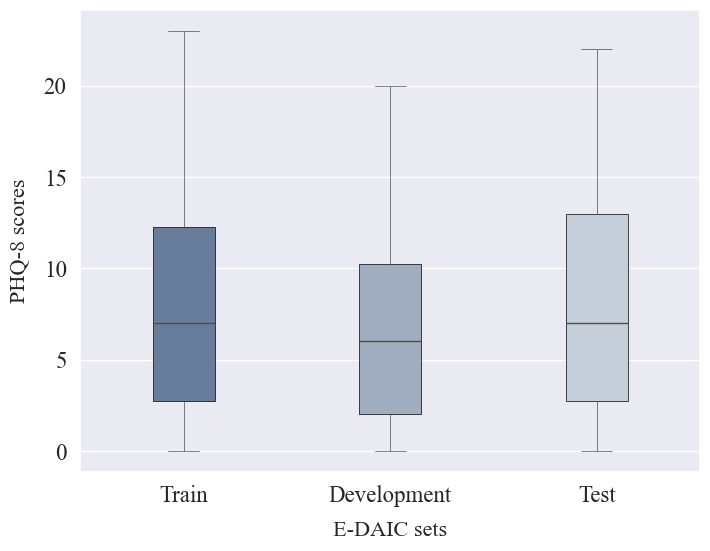

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Set font and style
sns.set(font='Times New Roman')
sns.set_context("notebook", font_scale=1.5)

# Read the CSV file
df = pd.read_csv('phq_scores.csv')

# Melt the DataFrame for Seaborn's boxplot
df_melted = pd.melt(df, var_name='Columns', value_name='Values')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Create a box plot with Seaborn
sns.boxplot(x='Columns', y='Values', data=df_melted, ax=ax,
             palette=cmaps.fau_light, width=0.3,  # <--- Use the custom color map
             flierprops={'marker': 'o', 'markersize': 1},
             boxprops={'linewidth': 0.5, 'edgecolor': 'black'},
             whiskerprops={'linewidth': 0.5, 'linestyle': '-'},
             capprops={'linewidth': 0.5, 'linestyle': '-'})

# Set title and labels
# Set title and labels
ax.set_ylabel('PHQ-8 scores', fontsize=16)
ax.set_xlabel('E-DAIC sets', fontsize=16)

# Add space between axis labels and tick labels
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

# Customize the plot
sns.set_style("whitegrid")
# sns.set_palette("pastel")

# Save the plot to a high-quality PDF file
plt.savefig('phq_scores_boxplot.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_3709/558024950.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


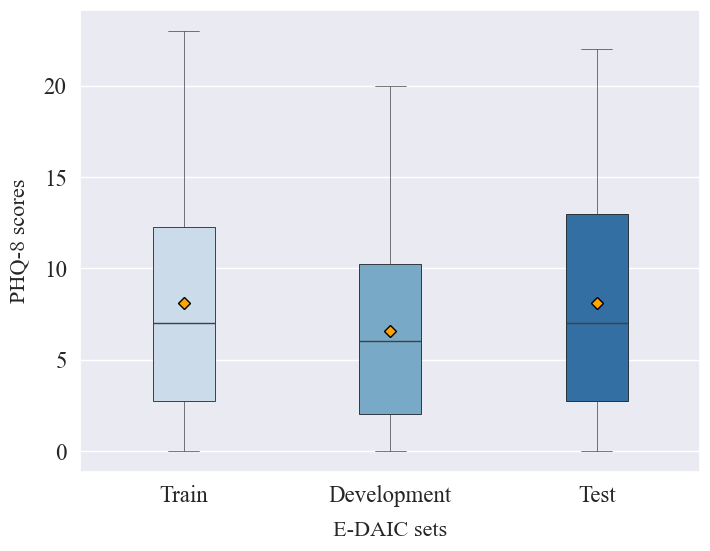

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Set font and style
sns.set(font='Times New Roman')
sns.set_context("notebook", font_scale=1.5)

# Read the CSV file
df = pd.read_csv('phq_scores.csv')

# Melt the DataFrame for Seaborn's boxplot
df_melted = pd.melt(df, var_name='Columns', value_name='Values')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Create a box plot with Seaborn, showing the mean with a dashed line
sns.boxplot(
    x='Columns', y='Values', data=df_melted, ax=ax,
    palette='Blues', width=0.3,
    showmeans=True,  # Show mean marker
    meanprops={
        'marker': 'D', 'markerfacecolor': 'orange', 'markeredgecolor': 'black',
        'markersize': 6, 'linestyle': '--', 'linewidth': 1.5
    },
    flierprops={'marker': 'o', 'markersize': 1},
    boxprops={'linewidth': 0.5, 'edgecolor': 'black'},
    whiskerprops={'linewidth': 0.5, 'linestyle': '-'},
    capprops={'linewidth': 0.5, 'linestyle': '-'}
)

# Set title and labels
ax.set_ylabel('PHQ-8 scores', fontsize=16)
ax.set_xlabel('E-DAIC sets', fontsize=16)

# Add space between axis labels and tick labels
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

# Customize the plot
sns.set_style("whitegrid")

# Save the plot to a high-quality PDF file
plt.savefig('phq_scores_boxplot_with_mean.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [44]:
# LSTM based feature extraction for teh ones who pass audio quality check

# Merge visual and text features for multi-modal prediction
import os
# import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
# from torchviz import make_dot
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the custom dataset class
class PHQDataset(Dataset):
    def __init__(self, csv_file, data_folder, max_seq_length=None, feature_type=None):
        self.data_folder = data_folder
        self.data_info = pd.read_csv(csv_file)
        self.max_seq_length = max_seq_length
        self.feature_type = feature_type
        self.scaler = StandardScaler()

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        participant_id = self.data_info.iloc[idx]['Participant_ID']
        phq_score = self.data_info.iloc[idx]['PHQ_Score']
        filepath = os.path.join(self.data_folder, f"{participant_id}_OpenFace2.1.0_Pose_gaze_AUs.csv")
        features_df = pd.read_csv(filepath)
        features_df = features_df.iloc[:, 2:]  # Remove the first two columns (frame and timestamp)
        # features = pd.read_csv(filepath).to_numpy()
        # features = features[:, 2:] # Remove the first two features (frame and timestamp)

        # Define column sets
        pose_columns = [col for col in features_df.columns if col.startswith('pose_')]
        gaze_columns = [col for col in features_df.columns if col.startswith('gaze_')]
        au_r_columns = [col for col in features_df.columns if col.endswith('_r')]
        au_c_columns = [col for col in features_df.columns if col.endswith('_c')]

        # Select columns based on feature type
        if self.feature_type == 'pose':
            selected_columns = pose_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze':
            selected_columns = gaze_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'au_r':
            selected_columns = au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'au_c':
            selected_columns = au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'confidence_success_pose':
            selected_columns = pose_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_gaze':
            selected_columns = gaze_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUintens':
            selected_columns = au_r_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUoccurr':
            selected_columns = au_c_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUoccurr_pose_gaze':
            selected_columns = au_c_columns + gaze_columns + pose_columns + ['confidence', 'success']
        elif self.feature_type == 'confidence_success_AUintens_pose_gaze':
            selected_columns = au_r_columns + gaze_columns + pose_columns + ['confidence', 'success']
        elif self.feature_type == 'pose_gaze':
            selected_columns = gaze_columns + pose_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_au_r':
            selected_columns = pose_columns + au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_au_c':
            selected_columns = pose_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze_au_r':
            selected_columns = gaze_columns + au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze_au_c':
            selected_columns = gaze_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'au_r_au_c':
            selected_columns = au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_gaze_au_r':
            selected_columns = pose_columns + gaze_columns + au_r_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_gaze_au_c':
            selected_columns = pose_columns + gaze_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'pose_au_r_au_c':
            selected_columns = pose_columns + au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'gaze_au_r_au_c':
            selected_columns = gaze_columns + au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'all':
            selected_columns = pose_columns + gaze_columns + au_r_columns + au_c_columns
            # Filter by confidence
            indices_to_remove = features_df[features_df['confidence'] < 0.9].index
            features_df = features_df.drop(index=indices_to_remove)
        elif self.feature_type == 'confidence_success_all':
            selected_columns = None
        else:
            selected_columns = None  # Use all columns if feature_type is not recognized
        
        if selected_columns is not None:
            features_df = features_df[selected_columns]
            # Remove rows with NaN values
            features_df = features_df.dropna()
            features = features_df.values
        else:
            # Remove rows with NaN values
            features_df = features_df.dropna()
            features = features_df.values
        
        # Apply feature normalization
        # features_normalized = self.scaler.fit_transform(features)
        # print("features_normalized shape: ", features_normalized.shape)

        # if self.max_seq_length is not None:
        #     padded_features = np.zeros((self.max_seq_length, features_normalized.shape[1]))
        #     padded_features[:features_normalized.shape[0], :features_normalized.shape[1]] = features_normalized
        #     features_normalized = padded_features

        # print('features.shape at the end: ', features.shape)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(phq_score, dtype=torch.float32)
        # return torch.tensor(features_normalized, dtype=torch.float32), torch.tensor(phq_score, dtype=torch.float32)

class Attention(nn.Module):
    def __init__(self, feature_dim, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.proj = nn.Linear(feature_dim, 64)
        self.context_vector = nn.Linear(64, 1, bias=False)

    def forward(self, x):
        x_proj = torch.tanh(self.proj(x))
        context_vector = self.context_vector(x_proj).squeeze(2)
        attention_weights = torch.softmax(context_vector, dim=1)
        weighted = torch.mul(x, attention_weights.unsqueeze(-1).expand_as(x))
        return torch.sum(weighted, dim=1)
    
# class EnhancedPHQLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=2, dropout_rate=0.5):
#         super(EnhancedPHQLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
#                             batch_first=True, bidirectional=True, dropout=dropout_rate)
#         self.attention = Attention(hidden_size * 2)
#         self.fc = nn.Linear(hidden_size * 2, 1)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         attn_out = self.attention(lstm_out)
#         # final_output = self.fc(lstm_out[:, -1, :])  # Taking the last output of the sequence to check the performance without attention layer
#         final_output = self.fc(attn_out)
#         return final_output

class EnhancedPHQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout_rate=0.5):
        super(EnhancedPHQLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.attention = Attention(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 128)  # Adjust the output size of the fully connected layer

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        return attn_out  # Return the output of the attention layer

    def get_last_fc_output(self, x):
        lstm_out, _ = self.lstm(x)
        # print("Shape of lstm_out:", lstm_out.shape)
        attn_out = self.attention(lstm_out)
        # print("Shape of attn_out:", attn_out.shape)
        fc_out = self.fc(attn_out)
        # print("Shape of fc_out:", fc_out.shape)
        
        # final_output_a = self.fc(lstm_out[:, -1, :]) 
        # print("Shape of final_output_a:", final_output_a.shape)
        # final_output_b = self.fc(attn_out)
        # print("Shape of final_output_b:", final_output_b.shape)
        # return fc_out
        return attn_out

criterion = nn.MSELoss()
mae = nn.L1Loss()

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_stack = torch.stack(yy, dim=0)
    return xx_pad, yy_stack, x_lens

# Define different combinations of feature types
feature_combinations = ['all', 'pose','gaze','au_r','au_c', \
                        'pose_gaze', 'pose_au_r', 'pose_au_c', \
                        'gaze_au_r', 'gaze_au_c', \
                        'au_r_au_c', \
                        'pose_gaze_au_r', 'pose_gaze_au_c', 'pose_au_r_au_c', 'gaze_au_r_au_c', \
                        'confidence_success_all', \
                        'confidence_success_AUintens', 'confidence_success_AUoccurr', \
                        'confidence_success_pose','confidence_success_gaze', \
                        'confidence_success_AUintens_pose_gaze', \
                        'confidence_success_AUoccurr_pose_gaze']


openface_data_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/DAIC_openface_features/"
labels_path = "/Users/misha/My_Projects/DAIC_Depression/depression-detection/data/labels/"

# Read labels
train_labels = pd.read_csv(os.path.join(labels_path, 'train_split.csv'))
dev_labels = pd.read_csv(os.path.join(labels_path, 'dev_split.csv'))
test_labels = pd.read_csv(os.path.join(labels_path, 'test_split.csv'))

# Convert labels to NumPy arrays
train_ids = train_labels['Participant_ID'].values
dev_ids = dev_labels['Participant_ID'].values
test_ids = test_labels['Participant_ID'].values

train_data_path = os.path.join(openface_data_path, "train")
dev_data_path = os.path.join(openface_data_path, "dev")
test_data_path = os.path.join(openface_data_path, "test")

train_dataset = PHQDataset(os.path.join(labels_path, 'train_split.csv'), train_data_path, feature_type="pose_gaze_au_r")

# train_IDs_mos_pred_below_2_5 = [302, 304, 305, 307, 308, 315, 316, 319, 323, 349, 354, 355, 375, 385, 387, 389, 397, 399, 406, 410, 416, 417, 420, 426, 427, 430, 432, 436, 438, 452, 453, 459, 461, 476, 487, 601, 603, 612, 628, 641, 654, 673, 677, 692, 695, 697, 702, 703, 707]
dev_IDs_mos_pred_below_2_5 =  [str(id) for id in [300, 306, 343, 347, 381, 388, 393, 401, 402, 408, 412, 431, 437, 441, 454, 479, 627, 653, 667, 670, 687]]
test_IDs_mos_pred_below_2_5 =  [str(id) for id in [600, 602, 606, 607, 609, 618, 622, 624, 626, 631, 635, 638, 650, 651, 655, 656, 658, 659, 663, 676, 679, 682, 683, 689, 693, 696, 699, 705, 709, 715, 716]]

# Read in the CSV files
dev_df = pd.read_csv(os.path.join(labels_path, 'dev_split.csv'))
test_df = pd.read_csv(os.path.join(labels_path, 'test_split.csv'))

# Ensure Participant_ID is of string type in DataFrame
dev_df['Participant_ID'] = dev_df['Participant_ID'].astype(str)
test_df['Participant_ID'] = test_df['Participant_ID'].astype(str)

# Filter rows where Participant_ID is NOT in the exclusion lists
filtered_dev_df = dev_df[~dev_df['Participant_ID'].isin(dev_IDs_mos_pred_below_2_5)]
filtered_test_df = test_df[~test_df['Participant_ID'].isin(test_IDs_mos_pred_below_2_5)]
print("filtered_dev_df: ", filtered_dev_df)
print("filtered_test_df: ", filtered_test_df)
# Define paths to save the filtered DataFrames
filtered_dev_file_path = os.path.join(labels_path, 'filtered_dev_split.csv')
filtered_test_file_path = os.path.join(labels_path, 'filtered_test_split.csv')
# Save the filtered DataFrames to new CSV files
filtered_dev_df.to_csv(filtered_dev_file_path, index=False)
filtered_test_df.to_csv(filtered_test_file_path, index=False)

dev_dataset = PHQDataset(os.path.join(labels_path, 'filtered_dev_split.csv'), dev_data_path, feature_type="pose_gaze_au_r")
test_dataset = PHQDataset(os.path.join(labels_path, 'filtered_test_split.csv'), test_data_path, feature_type="pose_gaze_au_r")

# dev_dataset = PHQDataset(os.path.join(labels_path, 'dev_split.csv'), dev_data_path, feature_type="pose_gaze_au_r")
# test_dataset = PHQDataset(os.path.join(labels_path, 'test_split.csv'), test_data_path, feature_type="pose_gaze_au_r")

# Load the pretrained model
model_path = "lstm_model_pose_gaze_au_r.pth"
pretrained_model = torch.load(model_path, map_location=torch.device('cpu'))

print("Model layers:")
for name, layer in pretrained_model.named_children():
    print(name, layer)

# Function to extract features from a dataset using the pretrained model
def extract_features_from_dataset(model, dataset):
    i = 0
    extracted_features = []
    model.eval()
    with torch.no_grad():
        for features, phq_scores in dataset:
            # print("features: ", features)
            # print("phq_scores: ", phq_scores)
            # print("i: ", i)
            features = features.unsqueeze(0).to(device)  # Add batch dimension if needed
            output = model.get_last_fc_output(features).squeeze().cpu().numpy()  # Get output from last fully connected layer
            # print("output shape: ", output.shape)
            extracted_features.append(output)
            i += 1
    return extracted_features


# # Extract features from train, test, and dev sets
train_features = extract_features_from_dataset(pretrained_model, train_dataset)
test_features = extract_features_from_dataset(pretrained_model, test_dataset)
dev_features = extract_features_from_dataset(pretrained_model, dev_dataset)

# Now train_features, test_features, and dev_features contain the extracted features for the respective datasets

# ================================================================================================================
# This is the code where we use the final trained LSTM model (lstm_model_pose_gaze_au_r.pth) to extract features.
# ================================================================================================================


Using device: cpu
filtered_dev_df:     Participant_ID  Gender  PHQ_Binary  PHQ_Score  PCL-C (PTSD)  PTSD Severity
1             301    male           0          3             0             17
3             317    male           0          8             1             51
4             320  female           0         11             1             64
5             321  female           1         20             1             62
6             331    male           0          8             1             61
7             334    male           0          5             0             32
8             336    male           0          7             0             29
10            344    male           0         11             0             56
12            350  female           1         11             1             54
13            365    male           1         12             1             43
14            371    male           0          9             0             40
15            373    male   

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_3709/1988308928.py:294: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load(model_path, ma

In [45]:
# =====================================
# Multimodal with audio quality check.   
# =====================================

import os
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager
from fau_colors import cmaps
import shap
from sklearn.preprocessing import StandardScaler

# Training and Evaluating and Testing --> 11 questions 

features_directory_org = './deproberta_features_fine_tuned_mode_based_on_prompts/original/'
features_directory_revised = './deproberta_features_fine_tuned_mode_based_on_prompts/revised/'


# scaler = MinMaxScaler()

def print_samples_with_id(y_true, y_pred, participant_ids, num_samples=10, tolerance=0.5):
    # Find indices where the predicted label differs by 10 or more from the true label
    large_diff_indices = np.where(np.abs(y_true - y_pred) >= 7)[0]
    
    # Find indices where the predicted label is very close to the true label
    small_diff_indices = np.where(np.abs(y_true - y_pred) <= tolerance)[0]

    # Print 10 samples with large differences
    print(f"\nSamples where the predicted score differs by 10 or more from the actual score (showing up to {num_samples} samples):")
    for index in large_diff_indices[:num_samples]:
        print(f"Index: {index}\tParticipant ID: {participant_ids[index]}\tTrue: {y_true[index]}\tPredicted: {y_pred[index]}")

    # Print 10 samples with small differences
    print(f"\nSamples where the predicted score is very close to the actual score (within {tolerance}, showing up to {num_samples} samples):")
    for index in small_diff_indices[:num_samples]:
        print(f"Index: {index}\tParticipant ID: {participant_ids[index]}\tTrue: {y_true[index]}\tPredicted: {y_pred[index]}")


# Function to convert string representation to NumPy array
def str_to_np_array(s):
    s = s.strip('[]')  # Remove square brackets
    return np.fromstring(s, sep=' ')

def ML_model_text_visual(prompt, org_revised, org_or_revised_dir):
    print('prompt: ', prompt)
    print('org_or_revised_dir: ', org_or_revised_dir)

    df_dev = pd.DataFrame()
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    csv_files = [file for file in os.listdir(org_or_revised_dir) if file.endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(org_or_revised_dir, file)
        if prompt in file:
            if 'train' in file:
                df_train = pd.read_csv(file_path)
            elif 'dev' in file:
                df_dev = pd.read_csv(file_path)
                # df_dev.drop(df_dev[df_dev['id'] == 347].index, inplace=True)
                # df_dev.drop(df_dev[df_dev['id'] == 388].index, inplace=True)
            elif 'test' in file:
                df_test = pd.read_csv(file_path)
                # df_test.drop(df_test[df_test['id'] == 640].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 638].index, inplace=True)
                # df_test.drop(df_test[df_test['id'] == 624].index, inplace=True)

    df_train.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_dev.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
    df_test.drop(columns=['Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'text'], inplace=True)
      
    if org_revised == 'org':
        merged_df_train = pd.merge(df_train, df_train_Q10_org, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_org, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_org, on='id', how='inner')
    elif org_revised =='revised':
        merged_df_train = pd.merge(df_train, df_train_Q10_revised, on='id', how='inner')
        merged_df_dev = pd.merge(df_dev, df_dev_Q10_revised, on='id', how='inner')
        merged_df_test = pd.merge(df_test, df_test_Q10_revised, on='id', how='inner')

    merged_with_quality = pd.merge(merged_df_train, train_set_audio_quality[['id', 'mos_pred']], on='id', how='left')
    # print('train merged_with_quality: ', merged_with_quality.head())

    ids_below_2 = merged_with_quality[merged_with_quality['mos_pred'] < 2.5]['id']
    print("train set IDs with mos_pred below 2.5:", ids_below_2.tolist())

    filtered_df = merged_with_quality[merged_with_quality['mos_pred'] >= 2.5]
    filtered_df = filtered_df.drop(columns=['mos_pred'])
    # merged_df_train = filtered_df

    # ----------------
    # print('merged_df_dev: ', merged_df_dev)
    # Merge the two DataFrames on the 'id' column to bring the `mos_pred` into `merged_df_dev`
    merged_with_quality = pd.merge(merged_df_dev, dev_set_audio_quality[['id', 'mos_pred']], on='id', how='left')
    # print('merged_with_quality: ', merged_with_quality.head())
    
    # Identify and print IDs where `mos_pred` is below 2
    ids_below_2 = merged_with_quality[merged_with_quality['mos_pred'] < 2.5]['id']
    print("dev set IDs with mos_pred below 2.5:", ids_below_2.tolist())

    # Filter out rows where `mos_pred` is below 2
    filtered_df = merged_with_quality[merged_with_quality['mos_pred'] >= 2.5]
    # Optionally, drop the `mos_pred` column if it's no longer needed
    filtered_df = filtered_df.drop(columns=['mos_pred'])
    merged_df_dev = filtered_df
    # Print the filtered DataFrame for verification
    # print('filtered_df: ', filtered_df.head())

    merged_with_quality = pd.merge(merged_df_test, test_set_audio_quality[['id', 'mos_pred']], on='id', how='left')
    ids_below_2 = merged_with_quality[merged_with_quality['mos_pred'] < 2.5]['id']
    print("test set IDs with mos_pred below 2.5:", ids_below_2.tolist())

    filtered_df = merged_with_quality[merged_with_quality['mos_pred'] >= 2.5]
    # Optionally, drop the `mos_pred` column if it's no longer needed
    filtered_df = filtered_df.drop(columns=['mos_pred'])
    merged_df_test = filtered_df

    # Get deproberta featrures
    # Convert string representation of list to actual list using ast.literal_eval
    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(str_to_np_array)
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(str_to_np_array)
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(str_to_np_array)

    merged_df_train['features_deproberta'] = merged_df_train['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_dev['features_deproberta'] = merged_df_dev['features_deproberta'].apply(lambda x: x.reshape(-1, 1))
    merged_df_test['features_deproberta'] = merged_df_test['features_deproberta'].apply(lambda x: x.reshape(-1, 1))

    # Extract Participant_IDs
    participant_ids_dev = merged_df_dev['id'].values
    participant_ids_test = merged_df_test['id'].values

    X_train = np.array([x.reshape(3) for x in merged_df_train['features_deproberta']])
    X_dev = np.array([x.reshape(3) for x in merged_df_dev['features_deproberta']])
    X_test = np.array([x.reshape(3) for x in merged_df_test['features_deproberta']])

    # Extract additional features
    additional_features = merged_df_train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    # Concatenate additional features with existing features_deproberta
    X_train = np.concatenate((X_train, additional_features), axis=1)
  
    # Adding the LSTM features to the textual features 
    # Convert train_features to a single numpy array
    train_features_array = np.vstack(train_features)        
    print('train_features_array shape: ', train_features_array.shape) 
    # Define PCA with desired number of components for LSTM features
    pca_lstm = PCA(n_components=10)
    # Fit PCA to LSTM features
    pca_lstm.fit(train_features_array)
    # Transform LSTM features
    train_features_array_pca = pca_lstm.transform(train_features_array)
    # Merge LSTM features with text features
    X_train = np.concatenate((X_train, train_features_array_pca), axis=1)
    print("Shape of X_train_merged after PCA:", X_train.shape)

    # # Convert train_features to a single numpy array
    # train_features_array = np.vstack(train_features)
    # # Merge train_features_array with X_train
    # X_train = np.concatenate((X_train, train_features_array), axis=1)
    # print("Shape of X_train_merged:", X_train.shape)

    # # Fit the scaler on training data and transform training data
    # additional_features_scaled_train = scaler.fit_transform(additional_features)
    # X_train = np.concatenate((X_train, additional_features_scaled_train), axis=1)

    # Define feature names
    deberta_features = ['Severe depression', 'Moderate depression', 'Not depression']
    # deberta's output: [n0, n1, n2] --> n0: severe, n1: moderate, n2: not depression 
    # questionnaire_features = [f'Q{i+1}' for i in range(11)]
    questionnaire_features = [
        "Q1: feeling_well",
        "Q2: mood_changes",
        "Q3: sleep_difficulties",
        "Q4: concentration_issues",
        "Q5: loss_of_interest",
        "Q6: depression_history",
        "Q7: PTSD_diagnosis",
        "Q8: financial_problems",
        "Q9: socializing",
        "Q10: suicidal_thoughts",
        "Q11: military_service"
    ]
    pca_features = [f'LSTM extracted {i+1}' for i in range(10)]
    all_features = deberta_features + questionnaire_features + pca_features

    # Similarly for dev and test sets
    additional_features_dev = merged_df_dev[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_dev = np.concatenate((X_dev, additional_features_dev), axis=1)
    dev_features_array = np.vstack(dev_features)
    print('dev_features_array shape: ', dev_features_array.shape) 
    dev_features_array_pca = pca_lstm.transform(dev_features_array)
    X_dev = np.concatenate((X_dev, dev_features_array_pca), axis=1)
    print("Shape of X_dev_merged after PCA:", X_dev.shape)

    # dev_features_array = np.vstack(dev_features)
    # X_dev = np.concatenate((X_dev, dev_features_array), axis=1)
    # print("Shape of X_dev_merged:", X_dev.shape)

    # # Similarly, transform dev and test data
    # additional_features_scaled_dev = scaler.transform(additional_features_dev)
    # X_dev = np.concatenate((X_dev, additional_features_scaled_dev), axis=1)

    additional_features_test = merged_df_test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']].values
    X_test = np.concatenate((X_test, additional_features_test), axis=1)
    test_features_array = np.vstack(test_features)
    print('test_features_array shape: ', test_features_array.shape) 
    test_features_array_pca = pca_lstm.transform(test_features_array)
    X_test = np.concatenate((X_test, test_features_array_pca), axis=1)
    print("Shape of X_test_merged after PCA:", X_test.shape)

    # test_features_array = np.vstack(test_features)
    # X_test = np.concatenate((X_test, test_features_array), axis=1)
    # print("Shape of X_test_merged:", X_test.shape)

    # additional_features_scaled_test = scaler.transform(additional_features_test)
    # X_test = np.concatenate((X_test, additional_features_scaled_test), axis=1)

    print('X_train shape: ', X_train.shape)
    print('X_dev shape: ', X_dev.shape)
    print('X_test shape: ', X_test.shape)

    y_train = np.array(merged_df_train['PHQ_Score'])
    y_dev = np.array(merged_df_dev['PHQ_Score'])
    y_test = np.array(merged_df_test['PHQ_Score'])

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon parameter
    }

    # Instantiate SVR
    svr = SVR(kernel='rbf')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV to your data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    print("Best params:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # svr = SVR(kernel='linear', C=1.0)  
    svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1) 
    # svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=1)   
    svr.fit(X_train, y_train)

    y_pred_dev = svr.predict(X_dev)
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev= mean_absolute_error(y_dev, y_pred_dev)
    print('RMSE for dev (PCA): ', np.sqrt(mse_dev))
    print('MAE for dev (PCA): ', mae_dev)

    y_pred_test = svr.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print('RMSE for test (PCA): ', np.sqrt(mse_test))
    print('MAE for test (PCA): ', mae_test)

    # Perform feature selection using SelectKBest
    selector = SelectKBest(f_regression, k=10)  # Select top 10 features
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_dev_selected = selector.transform(X_dev)
    X_test_selected = selector.transform(X_test)

    print('X_train_selected shape: ', X_train_selected.shape)
    print('X_dev_selected shape: ', X_dev_selected.shape)
    print('X_test_selected shape: ', X_test_selected.shape)

    # Report selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = [all_features[i] for i in selected_indices]
    print("Selected Features:")
    for feature in selected_features:
        print(feature)

    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
        'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon parameter
    }

    # Instantiate SVR
    svr = SVR(kernel='rbf')

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit GridSearchCV to your data
    grid_search.fit(X_train_selected, y_train)

    # Get the best parameters
    print("Best params:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    # svr = SVR(kernel='linear', C=1.0)  
    # svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=1) 
    svr = SVR(kernel='rbf', C=10, gamma='auto', epsilon=1)   
    svr.fit(X_train_selected, y_train)

    y_pred_train_selected = svr.predict(X_train_selected)
    mse_train_selected = mean_squared_error(y_train, y_pred_train_selected)
    mae_train_selected = mean_absolute_error(y_train, y_pred_train_selected)
    print('RMSE for train (selected features): ', np.sqrt(mse_train_selected))
    print('MAE for train (selected features): ', mae_train_selected)

    y_pred_dev_selected = svr.predict(X_dev_selected)
    mse_dev_selected = mean_squared_error(y_dev, y_pred_dev_selected)
    mae_dev_selected = mean_absolute_error(y_dev, y_pred_dev_selected)
    print('RMSE for dev (selected features): ', np.sqrt(mse_dev_selected))
    print('MAE for dev (selected features): ', mae_dev_selected)

    y_pred_test_selected = svr.predict(X_test_selected)
    mse_test_selected = mean_squared_error(y_test, y_pred_test_selected)
    mae_test_selected = mean_absolute_error(y_test, y_pred_test_selected)
    print('RMSE for test (selected features): ', np.sqrt(mse_test_selected))
    print('MAE for test (selected features): ', mae_test_selected)

    # You might need to scale the data back if it was scaled, to match original feature interpretations
    scaler = StandardScaler().fit(X_train_selected)
    X_train_inverse = scaler.inverse_transform(X_train_selected)

    # Kernel SHAP might be used as follows
    explainer = shap.KernelExplainer(svr.predict, X_train_inverse[:100])  # Kernel SHAP can be slow, so sample 
    shap_values = explainer.shap_values(X_train_inverse)

    # Visualize the first prediction's explanation
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_train_inverse[0], show=False)
    shap.save_html("shap_force_plot.html", shap.force_plot(explainer.expected_value, shap_values[0], X_train_inverse[0]))

    plt.figure()  
    # Adjust font size and remove grid
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 8,  # Adjust font size as needed
        'axes.grid': False,  # Remove grid
        'axes.facecolor': 'white'  # Set background to white
    })
    # Alternatively, for a global overview
    shap.summary_plot(shap_values, X_train_inverse, feature_names=selected_features, show=False)
    plt.gcf().savefig("shap_summary_plot_multimodal_with_speech_quality.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.close()

ML_model_text_visual('prompt3', 'org', features_directory_org)




prompt:  prompt3
org_or_revised_dir:  ./deproberta_features_fine_tuned_mode_based_on_prompts/original/
train set IDs with mos_pred below 2.5: [302, 304, 305, 307, 308, 315, 316, 319, 323, 349, 354, 355, 375, 385, 387, 389, 397, 399, 406, 410, 416, 417, 420, 426, 427, 430, 432, 436, 438, 452, 453, 459, 461, 476, 487, 601, 603, 612, 628, 641, 654, 673, 677, 692, 695, 697, 702, 703, 707]
dev set IDs with mos_pred below 2.5: [300, 306, 343, 347, 381, 388, 393, 401, 402, 408, 412, 431, 437, 441, 454, 479, 627, 653, 667, 670, 687]
test set IDs with mos_pred below 2.5: [600, 602, 606, 607, 609, 618, 622, 624, 626, 631, 635, 638, 650, 651, 655, 656, 658, 659, 663, 676, 679, 682, 683, 689, 693, 696, 699, 705, 709, 715, 716]
train_features_array shape:  (163, 128)
Shape of X_train_merged after PCA: (163, 24)
dev_features_array shape:  (35, 128)
Shape of X_dev_merged after PCA: (35, 24)
test_features_array shape:  (25, 128)
Shape of X_test_merged after PCA: (25, 24)
X_train shape:  (163, 24)
X_de

100%|██████████| 163/163 [01:34<00:00,  1.73it/s]


In [26]:
import seaborn as sns
from fau_colors import register_cmaps  # Use v2021 colors

# register_cmaps()  # Registers 2021 colormaps
sns.set_palette(sns.set_palette(cmaps.fau_dark))  # Set seaborn's color palette to a 2021 palette


In [27]:
import fau_colors 

fau_colors.register_cmaps()

AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

In [49]:
sns.set_palette(sns.color_palette('faculties_all', n_colors = 18))

ValueError: 'faculties_all' is not a valid palette name

In [61]:
from fau_colors import colors

colors.fau

'#002F6C'

In [69]:
from fau_colors import cmaps  # v2021 colors
# Only get the names here
cmaps._fields

('faculties',
 'faculties_dark',
 'faculties_light',
 'faculties_all',
 'fau',
 'fau_dark',
 'fau_light',
 'tech',
 'tech_dark',
 'tech_light',
 'phil',
 'phil_dark',
 'phil_light',
 'med',
 'med_dark',
 'med_light',
 'nat',
 'nat_dark',
 'nat_light',
 'wiso',
 'wiso_dark',
 'wiso_light')

In [70]:
cmaps.tech
# [(0.01568627450980392, 0.11764705882352941, 0.25882352941176473), (0.3823913879277201, 0.4463667820069205, 0.5349480968858131), (0.629434832756632, 0.6678200692041523, 0.7209688581314879), (0.7529565551710881, 0.7785467128027682, 0.8139792387543252), (0.876478277585544, 0.889273356401384, 0.9069896193771626)]

[(np.float64(0.4666666666666667),
  np.float64(0.6235294117647059),
  np.float64(0.7098039215686275)),
 (np.float64(0.6653594771241831),
  np.float64(0.7637831603229527),
  np.float64(0.8179161860822761)),
 (np.float64(0.7992156862745098),
  np.float64(0.8582698961937716),
  np.float64(0.8907497116493657)),
 (np.float64(0.8661437908496732),
  np.float64(0.9055132641291811),
  np.float64(0.9271664744329104)),
 (np.float64(0.9330718954248366),
  np.float64(0.9527566320645905),
  np.float64(0.9635832372164552))]

In [67]:
import seaborn as sns
sns.set_palette(cmaps.fau_dark)